In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os, time, stat, io
plt.style.use('fivethirtyeight')

# Reported Data
This data comes from JHU's COVID-19 dashboard: https://github.com/CSSEGISandData/COVID-19

In [64]:
# fileStatsObj = os.stat ( './time_series_19-covid-Deaths.csv' )
# modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )
# print("Last updated: ", modificationTime )
# df_deaths_raw = pd.read_csv('./time_series_19-covid-Deaths.csv')
# df_confirmed_raw = pd.read_csv('./time_series_19-covid-Confirmed.csv')
# df_recovered_raw = pd.read_csv('./time_series_19-covid-Recovered.csv')

In [65]:
# for requests
# os.environ['HTTP_PROXY'] = "http://fwdproxy:8080"
# os.environ['HTTPS_PROXY'] = "https://fwdproxy:8080"  

# # for urllib
# os.environ['http_proxy'] = "fwdproxy:8080"
# os.environ['https_proxy'] = "fwdproxy:8080"

deaths_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
confirmed_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_deaths_raw = pd.read_csv(deaths_url)
df_confirmed_raw = pd.read_csv(confirmed_url)
df_recovered_raw = pd.read_csv(recovered_url)
print("Last Updated: ", pd.Timestamp.today())

Last Updated:  2020-04-02 19:47:51.259690


In [66]:
df_states_raw = pd.read_csv('https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv')
df_states = df_states_raw.copy()
df_states['date'] = pd.to_datetime(df_states['date'], format="%Y%m%d")
print("State Testing Data Last Observation: ", df_states.date.max())
df_states = df_states.set_index(['state','date']).sort_index()
df_states.head()

State Testing Data Last Observation:  2020-04-02 00:00:00


positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   

                  ... hospitalized total  totalTestResults  posNeg  fips  \
state date        ...                                                      
AK    2020-03-06  ...          NaN     9                 8       8     2   
      2020-03-07  ...          NaN    14                12      12     2   
      2020-03-08  ...          NaN    20                14      14     2   
      2020-03-09  ...          NaN    32                23      23     2   
      2020-03-10  ...          NaN    32                23      23     2   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
AK    2020-03-06            NaN                   NaN               NaN   
      2020-03-07            0.0                   0.0               4.0   
      2020-03-08            0.0                   0.0               2.0   
      2020-03-09            0.0                   0.0               9.0   
      2020-03-10            0.0                   0.0               0.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
AK    2020-03-06               NaN                       NaN  
      2020-03-07               0.0                       4.0  
      2020-03-08               0.0                       2.0  
      2020-03-09               0.0                       9.0  
      2020-03-10               0.0                       0.0  

[5 rows x 23 columns]

In [67]:
def fix_raw_df(raw_df):
    col_rename = {'Province/State':'province', 'Country/Region':'country'}
    cleaned_df = raw_df.rename(columns=col_rename)
    cleaned_df = cleaned_df.set_index(['country','province'])
    cleaned_df = cleaned_df[[x for x in cleaned_df.columns if x not in ['Lat','Long']]]
    cleaned_df.columns = pd.to_datetime(cleaned_df.columns)
    cleaned_df.columns.name = 'dt'
    return cleaned_df

In [68]:
df_deaths = fix_raw_df(df_deaths_raw)
df_confirmed = fix_raw_df(df_confirmed_raw)
df_recovered = fix_raw_df(df_recovered_raw)
print("JHU Last Observation: ", df_recovered.columns.max())

JHU Last Observation:  2020-04-02 00:00:00


In [69]:
df_cases = pd.concat([df_confirmed.stack(),df_recovered.stack(),df_deaths.stack()], axis=1)
df_cases.columns = ['confirmed','recovered','deaths']
df_cases['resolved'] = df_cases['recovered'] + df_cases['deaths']
df_cases['outstanding'] = df_cases['confirmed'] - df_cases['resolved']
remove = df_cases.loc['US','confirmed'].unstack(0).iloc[-1].dropna().index.to_list()
# df_cases.loc[(['US'], remove,['2020-03-10']),:] = 0

country_dict={'Republic of Moldova':'Moldova',
 'Hong Kong SAR':'Hong Kong',
 'Iran (Islamic Republic of)':'Iran',
 'Republic of Korea':'South Korea',
 'Russian Federation':'Russia',
              'Macao SAR':'Macau',
              'China':'Mainland China'
}
df_cases = df_cases.rename(index=country_dict)
df_cases.head()

/data/users/mdonnelly/.bento/kernels/bento_kernel_default/latest/bento_kernel_default:5: PerformanceWarning:

indexing past lexsort depth may impact performance.



confirmed  recovered  deaths  resolved  \
country     province dt                                                   
Afghanistan NaN      2020-01-22        0.0          0     0.0       0.0   
                     2020-01-23        0.0          0     0.0       0.0   
                     2020-01-24        0.0          0     0.0       0.0   
                     2020-01-25        0.0          0     0.0       0.0   
                     2020-01-26        0.0          0     0.0       0.0   

                                 outstanding  
country     province dt                       
Afghanistan NaN      2020-01-22          0.0  
                     2020-01-23          0.0  
                     2020-01-24          0.0  
                     2020-01-25          0.0  
                     2020-01-26          0.0

In [70]:
# df_cases.index.levels[1].tolist()

In [71]:
df_cases_global = df_cases.groupby(level='dt').sum()
df_cases_global['country'] = 'Global'
df_cases_global = df_cases_global.reset_index().set_index(['country','dt'])
df_cases_global.tail()

confirmed  recovered   deaths  resolved  outstanding
country dt                                                              
Global  2020-03-29   720117.0     156072  33925.0  189531.0     530586.0
        2020-03-30   782365.0     171556  37582.0  208672.0     573693.0
        2020-03-31   857487.0     201914  42107.0  242429.0     615058.0
        2020-04-01   932605.0     213037  46809.0  258522.0     674083.0
        2020-04-02  1013157.0     236288  52983.0  287536.0     725621.0

In [72]:
df_cases_country = df_cases.groupby(level=['country','dt']).sum()
df_cases_country = pd.concat([df_cases_country,df_cases_global], sort=True)
df_cases_country['resolved_mortality_rate'] = df_cases_country['deaths']/df_cases_country['resolved']
df_cases_country['unresolved_mortality_rate'] = df_cases_country['deaths']/df_cases_country['confirmed']
df_cases_country.head(2)

confirmed  deaths  outstanding  recovered  resolved  \
country     dt                                                                
Afghanistan 2020-01-22        0.0     0.0          0.0          0       0.0   
            2020-01-23        0.0     0.0          0.0          0       0.0   

                        resolved_mortality_rate  unresolved_mortality_rate  
country     dt                                                              
Afghanistan 2020-01-22                      NaN                        NaN  
            2020-01-23                      NaN                        NaN

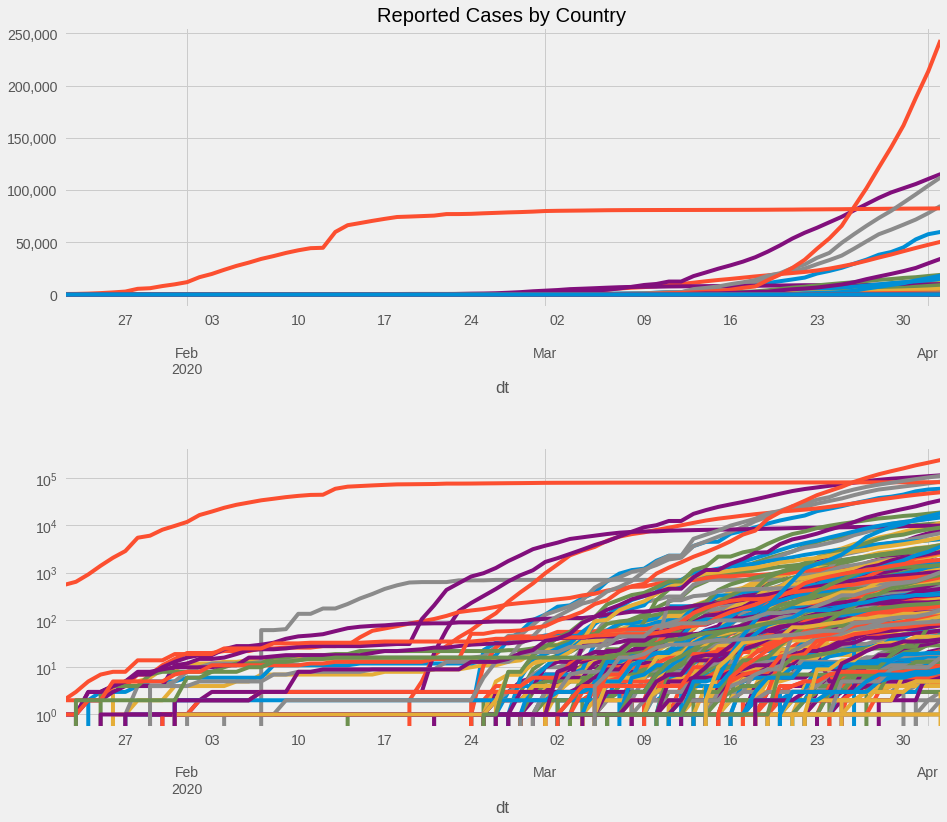

In [73]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[14,12])
chart = df_cases_country.unstack(0)['confirmed']
chart = chart[[country for country in chart.columns if country not in ['Global']]]
ax0=chart.plot(logy=False, ax=axes[0])
ax0.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
_ = ax0.set_title('Reported Cases by Country')
# ax0.legend(bbox_to_anchor=(1, 1))
ax1=chart.plot(logy=True, ax=axes[1])
ax0.legend_.remove()
ax1.legend_.remove()

In [74]:
df_cases_country.unstack(0)['confirmed'].sort_index().iloc[-1].sort_values(ascending=False)

country
Global                              1013157.0
US                                   243453.0
Italy                                115242.0
Spain                                112065.0
Germany                               84794.0
                                      ...    
Malawi                                    3.0
Sierra Leone                              2.0
Saint Vincent and the Grenadines          2.0
Timor-Leste                               1.0
Papua New Guinea                          1.0
Name: 2020-04-02 00:00:00, Length: 182, dtype: float64

'US cases:'

dt
2020-03-29    140886.0
2020-03-30    161807.0
2020-03-31    188172.0
2020-04-01    213372.0
2020-04-02    243453.0
Name: US, dtype: float64

'change in US cases:'

dt
2020-03-29    19408.0
2020-03-30    20921.0
2020-03-31    26365.0
2020-04-01    25200.0
2020-04-02    30081.0
Name: US, dtype: float64

'acceleration in US cases:'

dt
2020-03-29    -413.0
2020-03-30    1513.0
2020-03-31    5444.0
2020-04-01   -1165.0
2020-04-02    4881.0
Name: US, dtype: float64

'rolling 7 day avg acceleration in US cases:'

dt
2020-03-29    1660.142857
2020-03-30    1478.571429
2020-03-31    2353.142857
2020-04-01    1880.285714
2020-04-02    1717.571429
Name: US, dtype: float64

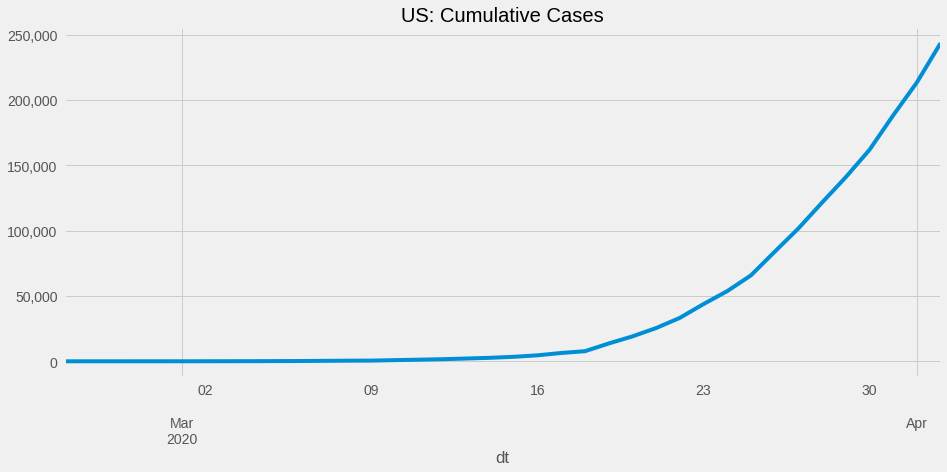

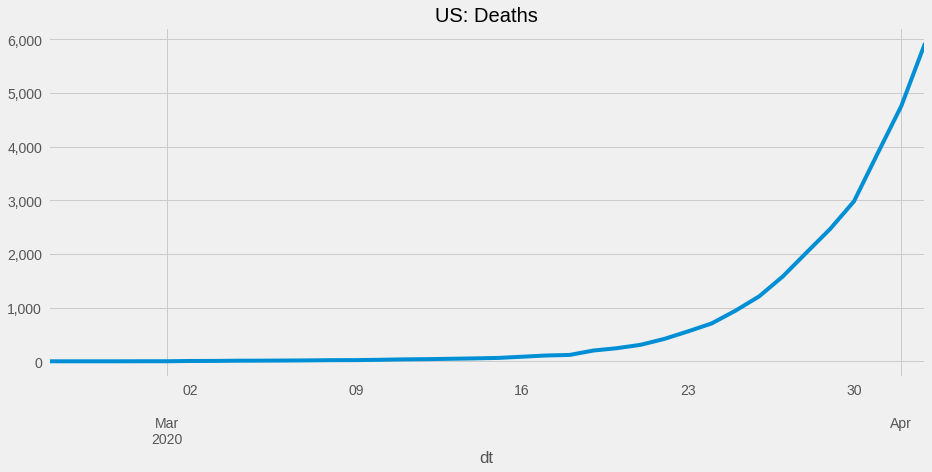

In [75]:
display('US cases:',
        df_cases_country.unstack(0)['confirmed']['US'].loc['2020-02-25':].dropna().tail(5))
display('change in US cases:',
        df_cases_country.unstack(0)['confirmed']['US'].loc['2020-02-25':].diff().dropna().tail(5))
display('acceleration in US cases:',
        df_cases_country.unstack(0)['confirmed']['US'].loc['2020-02-25':].diff().diff().dropna().tail(5))
display('rolling 7 day avg acceleration in US cases:',
        df_cases_country.unstack(0)['confirmed']['US'].loc['2020-02-25':].diff().diff().rolling(7).mean().dropna().tail(5))
ax = df_cases_country.unstack(0)['confirmed']['US'].loc['2020-02-25':]\
.plot(title='US: Cumulative Cases',
      figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()
ax = df_cases_country.unstack(0)['deaths']['US'].loc['2020-02-25':]\
.plot(title='US: Deaths',
      figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

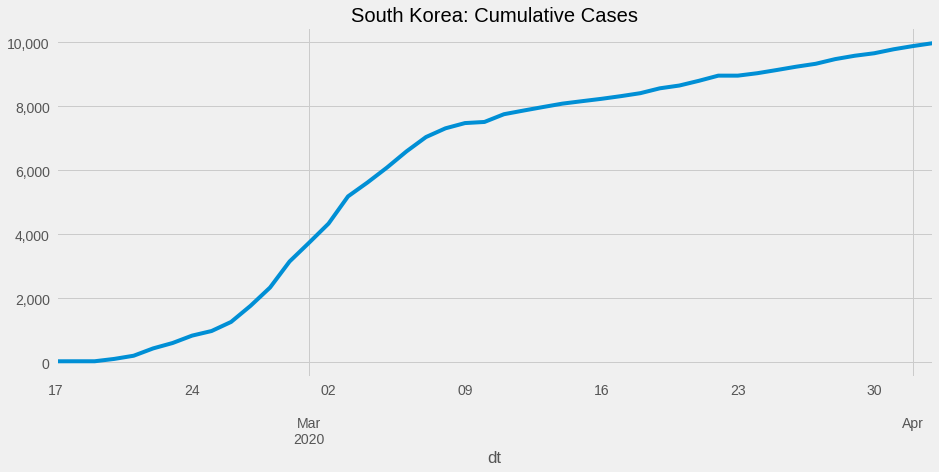

In [76]:
ax = df_cases_country.unstack(0)['confirmed']['Korea, South'].loc['2020-02-17':]\
.plot(title='South Korea: Cumulative Cases',
      figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

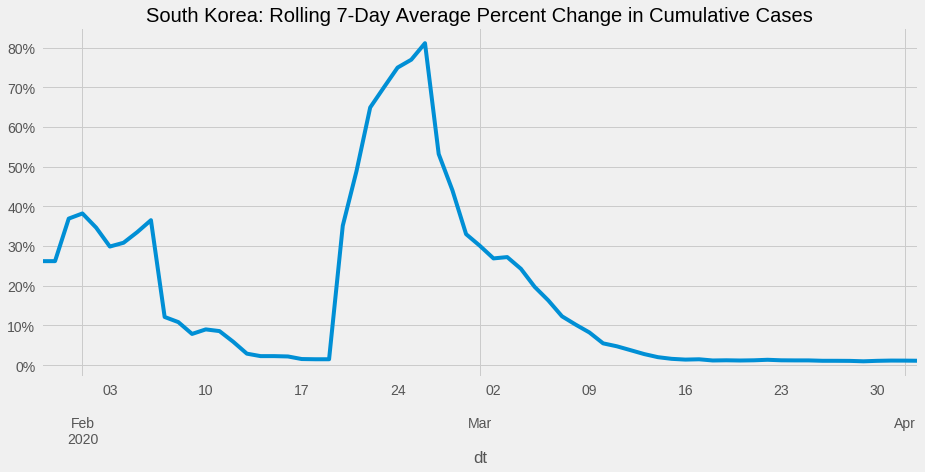

In [77]:
ax = df_cases_country.unstack(0)['confirmed']['Korea, South'].pct_change().rolling(7).mean().dropna()\
.plot(title='South Korea: Rolling 7-Day Average Percent Change in Cumulative Cases',
      figsize=[14,6])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0%}'))

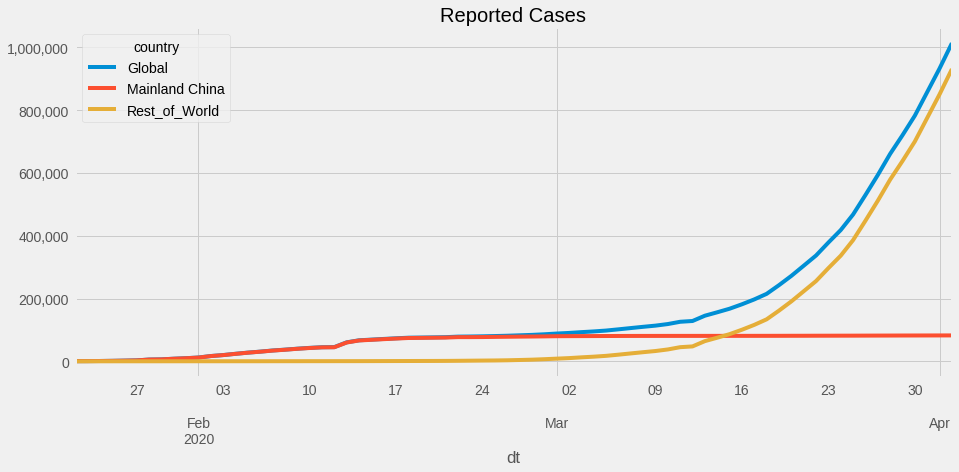

In [78]:
chart = df_cases_country.unstack(0)['confirmed']
not_china_or_global = [country for country in chart.columns if country not in ['Global','Mainland China']]
chart['Rest_of_World'] = chart[not_china_or_global].sum(axis=1)
ax = chart[['Global','Mainland China','Rest_of_World']].plot(figsize=[14,6])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
_ = ax.set_title('Reported Cases')


In [79]:
chart[['Mainland China','Rest_of_World']].div(chart['Global'], axis=0).tail(14)

country,Mainland China,Rest_of_World
dt,,
2020-03-20,0.298675,0.701325
2020-03-21,0.267103,0.732897
2020-03-22,0.241681,0.758319
2020-03-23,0.215469,0.784531
2020-03-24,0.195173,0.804827
2020-03-25,0.174619,0.825381
2020-03-26,0.154425,0.845575
2020-03-27,0.138039,0.861961
2020-03-28,0.124108,0.875892


## Mortality Rates (Resolved vs confirmed)
The mortality rate is defined as _deaths attributable to Covid-19_ / _cases of Covid-19_. The estimate for the denominator matters a great deal. Here are two commonly cited versions:
 - *Resolved mortality rate* This rate uses the total of all resolved cases as the denominator. In other words: recovered cases + deaths. This should be regarded as the upper bound and even then is probably much too high. Deaths are likely detected as being attributable to Covid-19 than recovered cases, thus heavily biasing the estimator.
 - *Confirmed mortality rate* This rate uses the cumulative total of all reported cases as the denominator. This one is likely closer, however there is still several sources of bias. One bias comes from the fact that some cases are not yet reported, which would likely overstate the estimate. Another bias comes from including seriously ill people who may die in the future, which would understate the estimate.

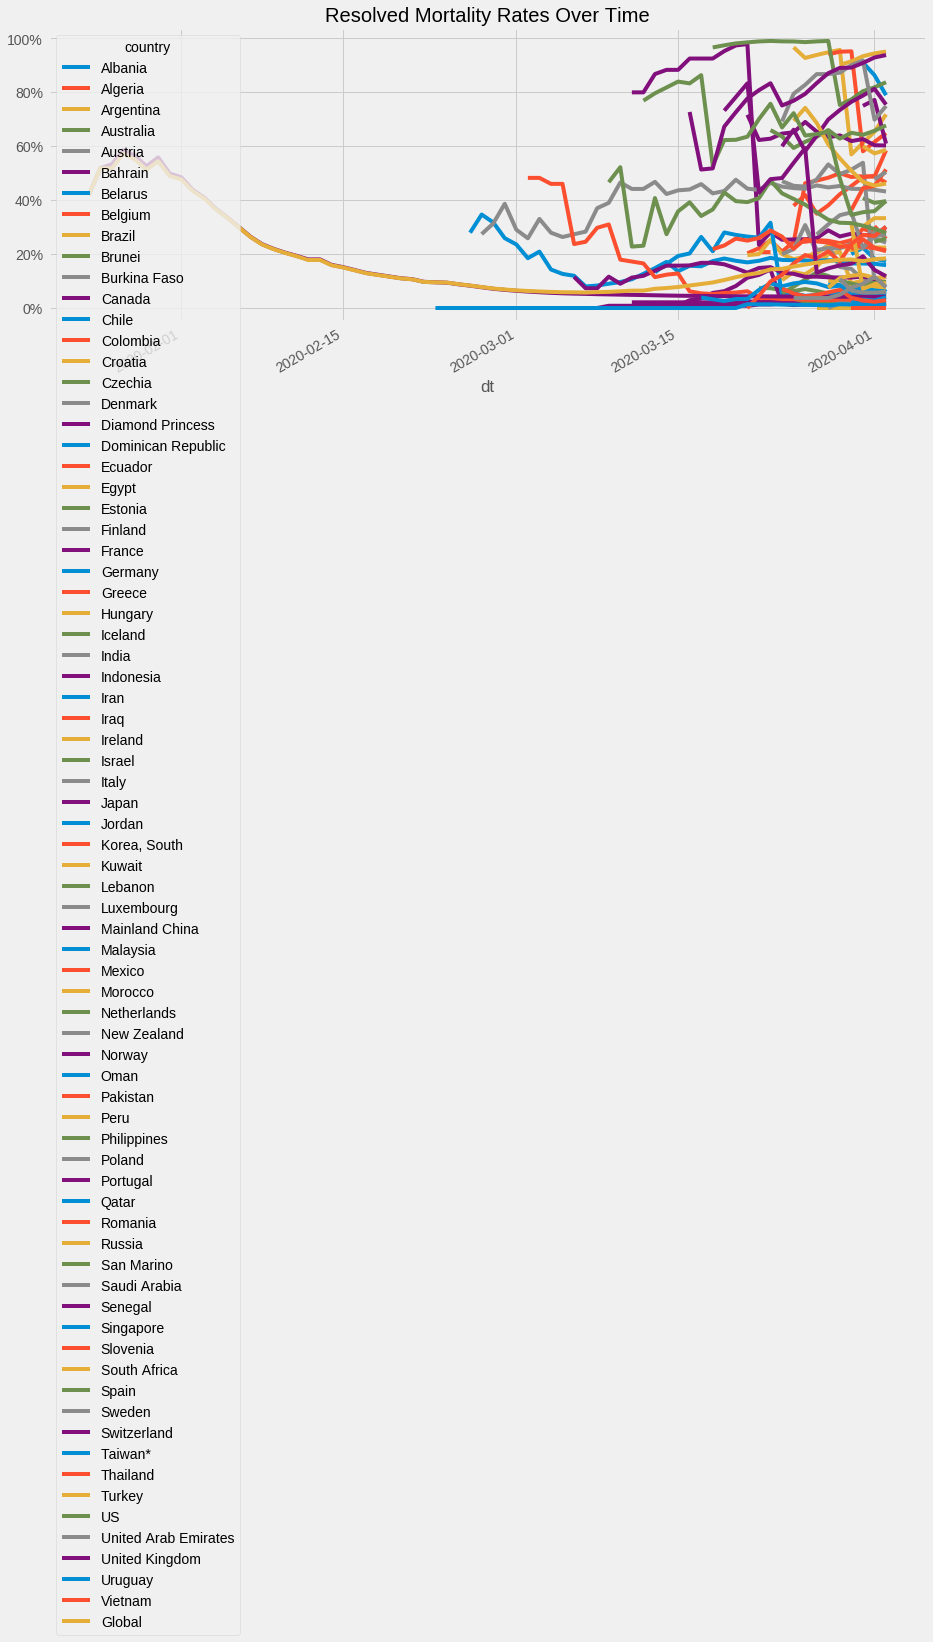

In [80]:
ts_resolved_mortality_rate = df_cases_country[df_cases_country.resolved>=50] \
['resolved_mortality_rate'].unstack(0)

ax = ts_resolved_mortality_rate.plot(title='Resolved Mortality Rates Over Time',
                                    figsize=[14,6])
_ = ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])


In [81]:
ts_resolved_mortality_rate.sort_index().tail()

country,Albania,Algeria,Argentina,Australia,Austria,Bahrain,Belarus,Belgium,Brazil,Brunei,...,Switzerland,Taiwan*,Thailand,Turkey,US,United Arab Emirates,United Kingdom,Uruguay,Vietnam,Global
dt,,,,,,,,,,,,,,,,,,,,,
2020-03-29,NaN,0.500000,0.208791,0.061538,0.152212,0.014493,NaN,0.240782,0.957746,NaN,...,0.158311,NaN,0.067308,0.555085,0.480709,0.049180,0.890738,NaN,NaN,0.178994
2020-03-30,0.200000,0.486111,0.091633,0.062044,0.145161,0.014134,NaN,0.251471,0.569892,NaN,...,0.164528,NaN,0.037815,0.509091,0.345395,0.075758,0.891909,NaN,0.0,0.180101
2020-03-31,0.223881,0.488889,0.101124,0.047872,0.104661,0.013378,NaN,0.293628,0.612805,NaN,...,0.191933,NaN,0.028409,0.468271,0.355419,0.089552,0.909229,NaN,0.0,0.173688
2020-04-01,0.182927,0.487395,0.101449,0.045249,0.092288,0.011730,0.036364,0.279730,0.653951,0.018868,...,0.141245,NaN,0.023211,0.454098,0.359534,0.115942,0.929416,NaN,0.0,0.181064
2020-04-02,0.173913,0.585034,0.123288,0.044118,0.082853,0.010390,0.070175,0.288363,0.718404,0.017544,...,0.117828,0.1,0.028846,0.461738,0.396999,0.076923,0.938422,0.060606,0.0,0.184266


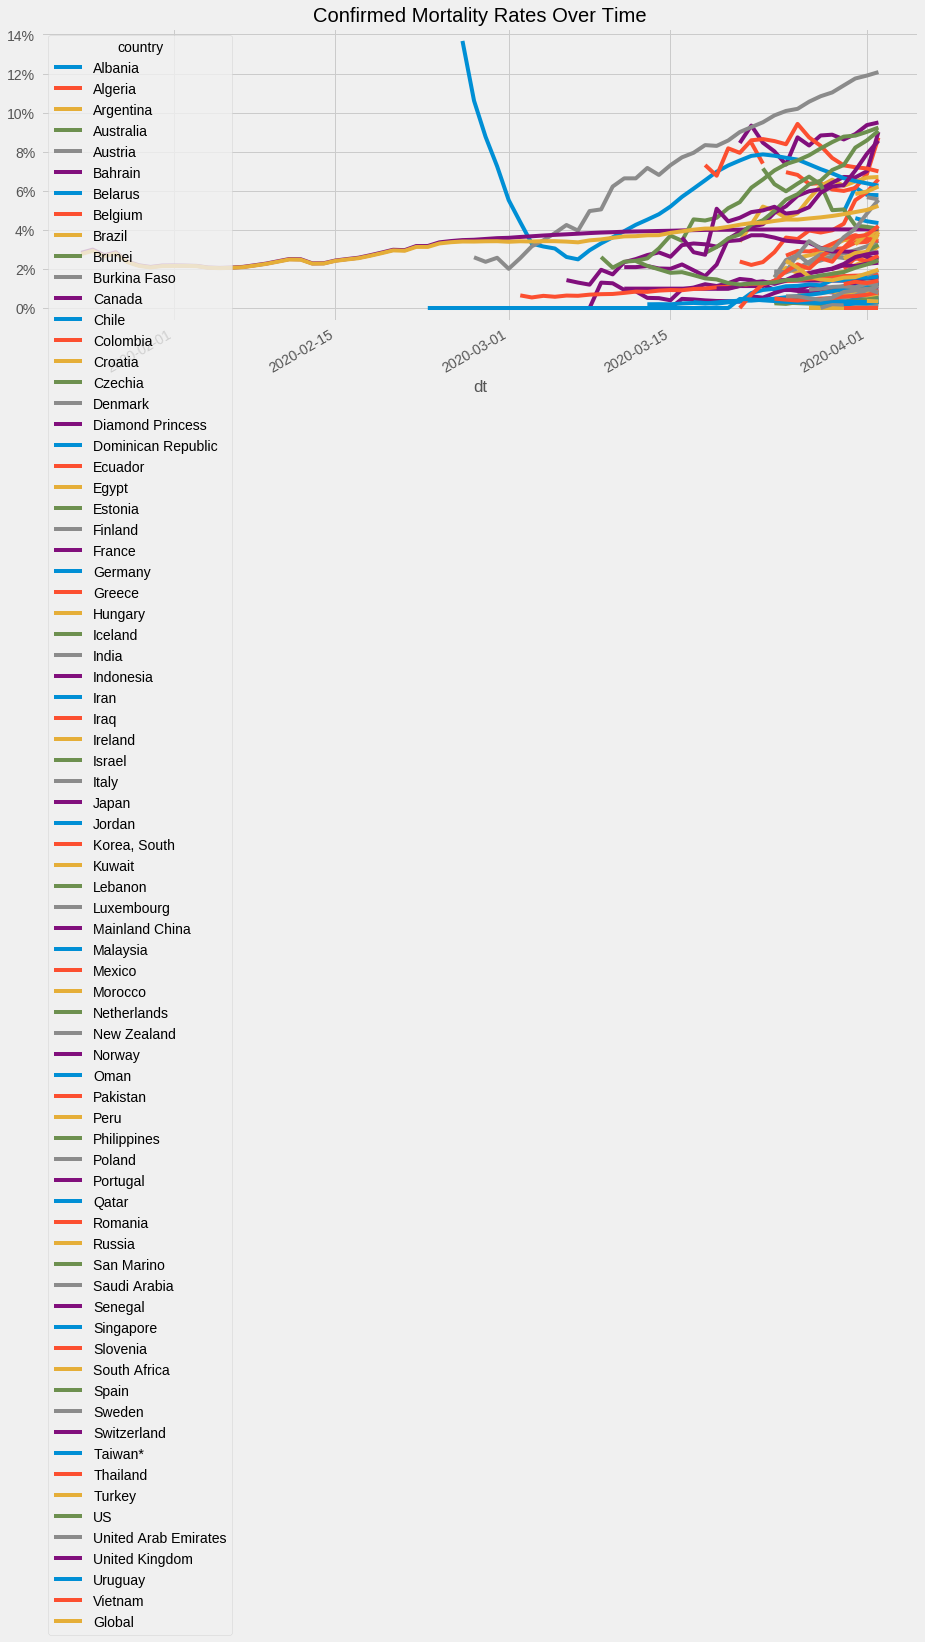

In [82]:
ts_unresolved_mortality_rate = df_cases_country[df_cases_country.resolved>=50] \
['unresolved_mortality_rate'].unstack(0)

ax = ts_unresolved_mortality_rate.plot(title='Confirmed Mortality Rates Over Time',
                                    figsize=[14,6])
_ = ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])


In [83]:
ts_unresolved_mortality_rate.sort_index().tail(5)

country,Albania,Algeria,Argentina,Australia,Austria,Bahrain,Belarus,Belgium,Brazil,Brunei,...,Switzerland,Taiwan*,Thailand,Turkey,US,United Arab Emirates,United Kingdom,Uruguay,Vietnam,Global
dt,,,,,,,,,,,,,,,,,,,,,
2020-03-29,NaN,0.060665,0.025503,0.004016,0.009786,0.008016,NaN,0.039775,0.031955,NaN,...,0.020231,NaN,0.005043,0.014213,0.017511,0.005263,0.062235,NaN,NaN,0.047110
2020-03-30,0.049327,0.059932,0.028049,0.003898,0.011229,0.007767,NaN,0.043113,0.034724,NaN,...,0.022547,NaN,0.005906,0.015517,0.018405,0.008183,0.062842,NaN,0.0,0.048036
2020-03-31,0.061728,0.061453,0.025617,0.003948,0.012574,0.007055,NaN,0.055186,0.035158,NaN,...,0.026076,NaN,0.006057,0.015816,0.020582,0.009036,0.070366,NaN,0.0,0.049105
2020-04-01,0.057915,0.068477,0.026565,0.004114,0.013631,0.007030,0.012270,0.059295,0.035108,0.007634,...,0.027465,NaN,0.006776,0.017667,0.022294,0.009828,0.078922,NaN,0.0,0.050192
2020-04-02,0.057762,0.087221,0.031774,0.004691,0.014197,0.006221,0.013158,0.065872,0.040278,0.007519,...,0.028470,0.014749,0.008000,0.019631,0.024341,0.007812,0.085623,0.011429,0.0,0.052295


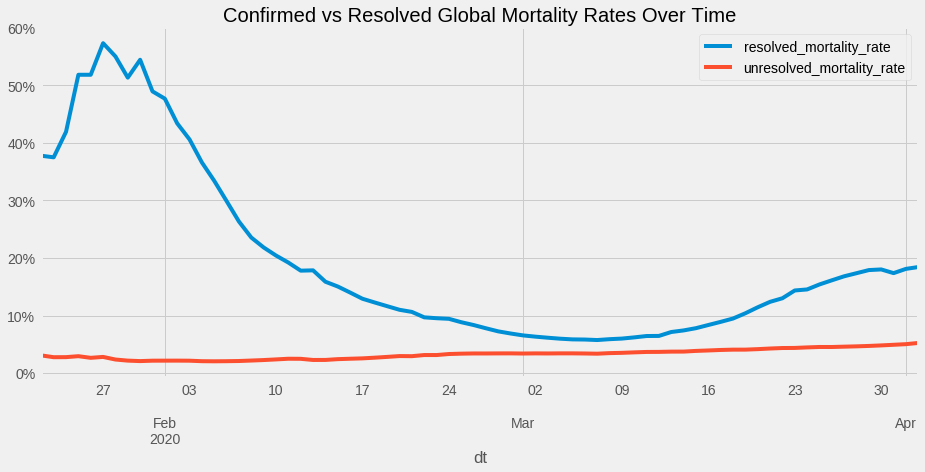

In [84]:
chartdata=df_cases_country.loc['Global',['resolved_mortality_rate','unresolved_mortality_rate']]
ax = chartdata.plot(title='Confirmed vs Resolved Global Mortality Rates Over Time',
                                    figsize=[14,6])
_ = ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])


In [85]:
chartdata.tail(1)

,resolved_mortality_rate,unresolved_mortality_rate
dt,,
2020-04-02,0.184266,0.052295


# Inflating observed to likely real rate

## Impact of Asymptomatic Cases on the True Numbers
Let's start by assuming an asymptomatic rate of 30% See Bibliography. This rate may be too low, per authors' warning. This would be because of the older skewed population on the cruise, meaning that they are more likely to show symptoms than the general population.

In [86]:
df_asympt = df_cases_country.copy()

asympt_rate_obs = 0.3 #Published asymptomatic rate
asympt_rate_bias = 0.0 #We can use this to adjust the asymptomatic rate later.
asympt_rate_est = asympt_rate_obs + asympt_rate_bias #Adjusted for bias

# Assume that confirmed cases are not counting asymptomatic cases.
df_asympt['est_infected'] = df_asympt['confirmed']/(1-asympt_rate_est)

# Since there are no symptoms, there should be no morbidity/mortality, i.e. 100% recovered 
# among asymptomatics. However, they only "recover" (i.e., are not infectious after 14 days)
asympt_recovered = (df_asympt['est_infected'] - df_asympt['confirmed']).unstack('dt')\
    .transpose().shift(14).stack(0).reorder_levels(df_asympt.index.names)

df_asympt['est_recovered'] = df_asympt['recovered'].add(asympt_recovered, fill_value=0)

# Deaths should not be effected by the asymptomatic rate
df_asympt['est_deaths'] = df_asympt['deaths']

# Resolved is definded as Recovered + deaths
df_asympt['est_resolved'] = df_asympt['est_recovered'].add(df_asympt['est_deaths'], fill_value=0)

# Outstanding cases are the remainder
df_asympt['est_outstanding'] = df_asympt['est_infected'].subtract(df_asympt['est_resolved'], fill_value=0)


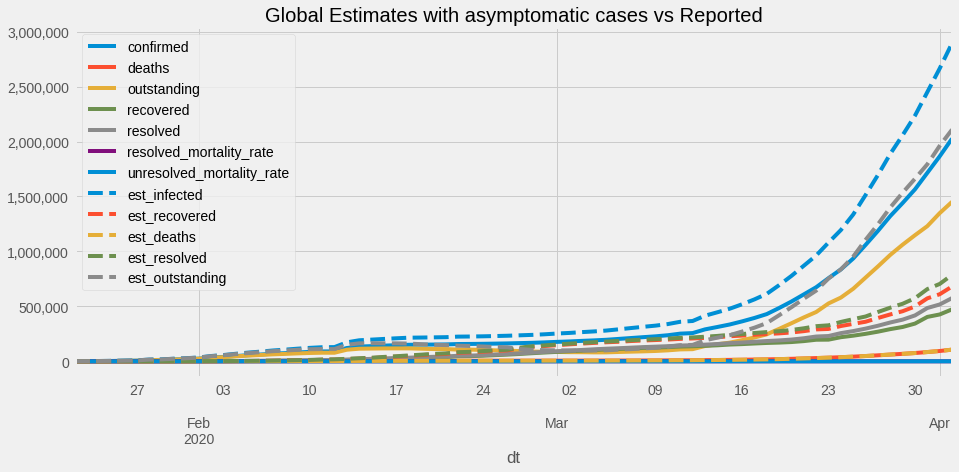

In [87]:
est_cols = [col for col in df_asympt.columns if "est_" in col]
reported_cols = [col for col in df_asympt.columns if "est_" not in col]
# ax = df_asympt.groupby(level='dt').sum().plot(style=['-']*5+['--']*5, figsize=[14,6])

ax = df_asympt.groupby(level='dt').sum()[reported_cols].plot(style=['-']*5, figsize=[14,6])
plt.gca().set_prop_cycle(None)
df_asympt.groupby(level='dt').sum()[est_cols].plot(style=['--']*5, ax=ax)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
_ = ax.set_title('Global Estimates with asymptomatic cases vs Reported')

In [88]:
# Recalculate rates
df_asympt['est_resolved_mortality_rate'] = df_asympt['est_deaths']/df_asympt['est_resolved']
df_asympt['est_unresolved_mortality_rate'] = df_asympt['est_deaths']/df_asympt['est_infected']


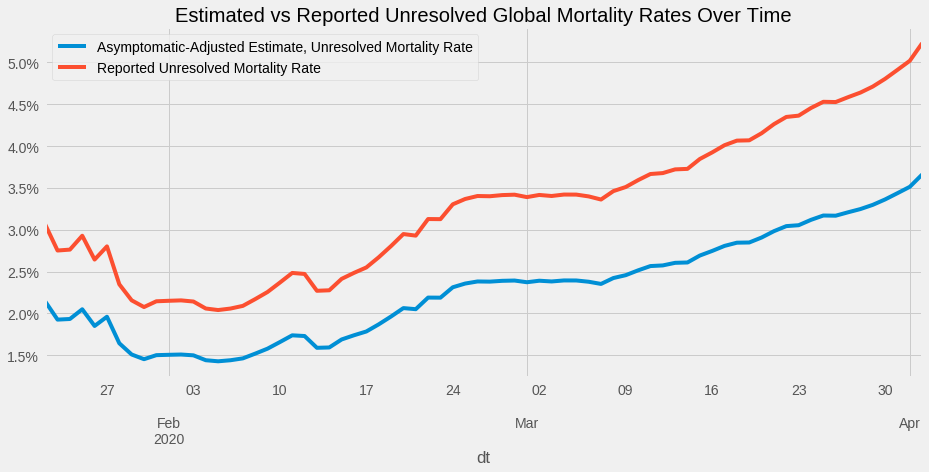

In [89]:
chart = (df_asympt['est_deaths'].groupby(level=['dt']).sum()
         /df_asympt['est_infected'].groupby(level=['dt']).sum()
        )
ax = chart.plot(title='Estimated vs Reported Unresolved Global Mortality Rates Over Time',
                figsize=[14,6], label='Asymptomatic-Adjusted Estimate, Unresolved Mortality Rate',
               legend=True)

chartdata=df_cases_country.loc['Global','unresolved_mortality_rate']
chartdata.plot(ax=ax,
              label='Reported Unresolved Mortality Rate', legend=True)
# _ = ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])

_ = ax.set_yticklabels(['{:.1%}'.format(x) for x in ax.get_yticks()])


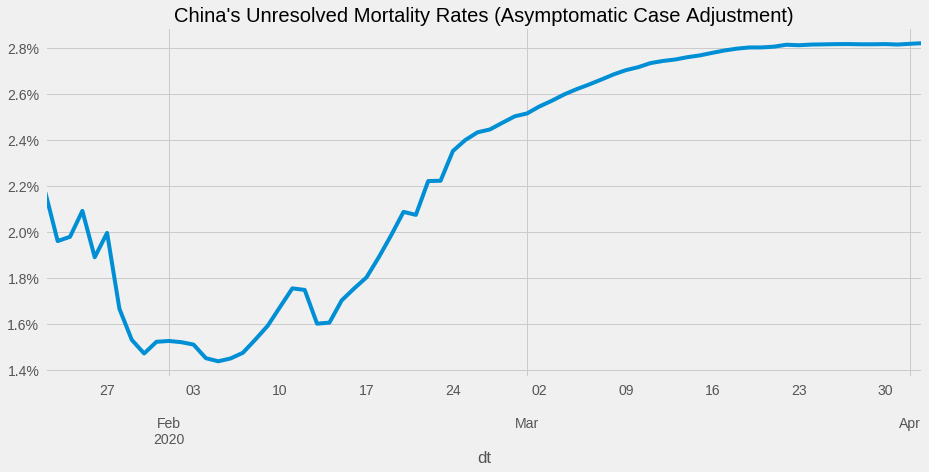

In [90]:
chart = (df_asympt['est_deaths'].groupby(level=['country','dt']).sum()
         /df_asympt['est_infected'].groupby(level=['country','dt']).sum()
        ).loc['Mainland China']
ax = chart.plot(title="China's Unresolved Mortality Rates (Asymptomatic Case Adjustment)",
                figsize=[14,6])
_ = ax.set_yticklabels(['{:.1%}'.format(x) for x in ax.get_yticks()])


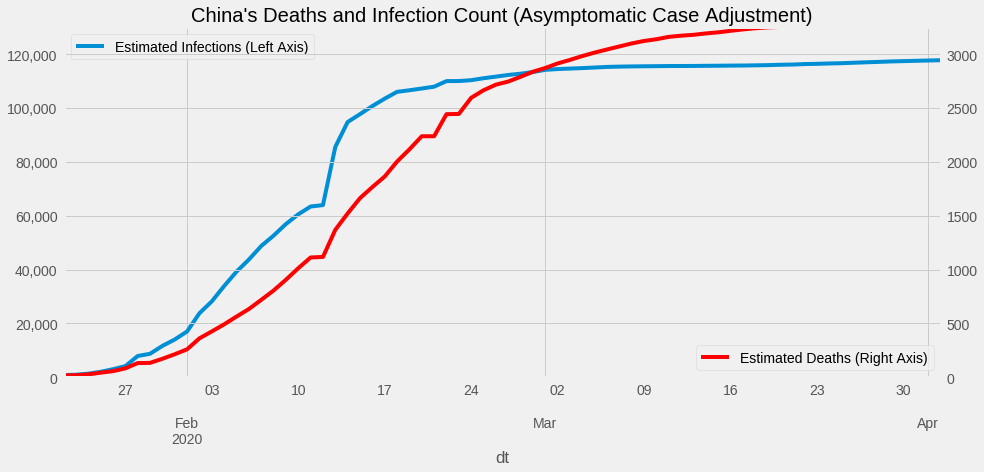

In [91]:
chart = df_asympt.groupby(level=['country','dt']).sum()[['est_deaths','est_infected']
                                                       ].loc['Mainland China']
ax = chart['est_infected'].plot(title="China's Deaths and Infection Count (Asymptomatic Case Adjustment)",
                figsize=[14,6], legend=True)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0, 130000])
plt.legend(['Estimated Infections (Left Axis)'], loc='upper left')
ax2 = ax.twinx()
chart['est_deaths'].plot(ax=ax2, color='r', legend=True)
ax2.set_ylim([0, 3250])
_ = plt.legend(['Estimated Deaths (Right Axis)'], loc='lower right')


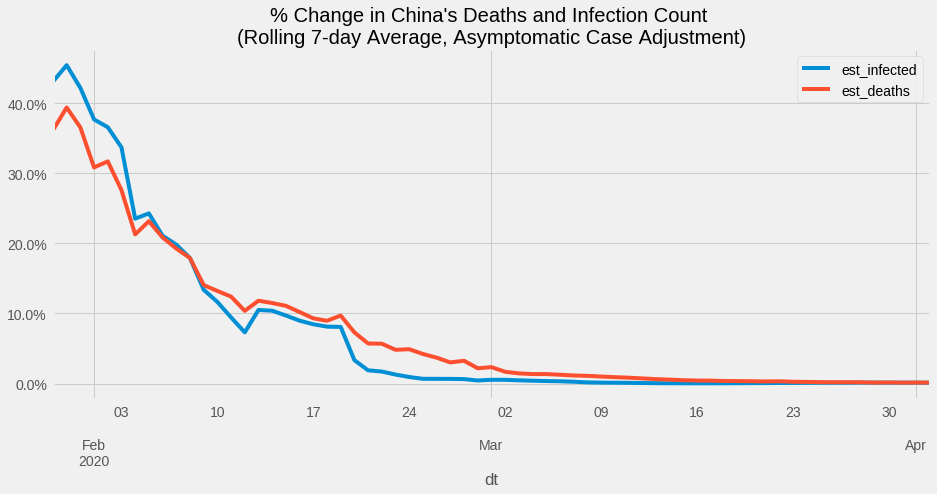

In [92]:
chart = df_asympt.groupby(level=['country','dt']).sum()[['est_infected','est_deaths']
                                                       ].loc['Mainland China'].pct_change().rolling(7).mean()
ax = chart.dropna().plot(title="""% Change in China's Deaths and Infection Count \n(Rolling 7-day Average, Asymptomatic Case Adjustment)""",
                figsize=[14,6])
_ = ax.set_yticklabels(['{:.1%}'.format(x) for x in ax.get_yticks()])


Note: New infections have been slowing more than new deaths in China. This is the reason for the higher estimated mortality rate. Might make sense that China is underreporting new infections. Suggesting further spread and vulnerability in that country. OR... the mortality rate is higher than other indications.

## Impact of detection rate
Detection (i.e. correct attribution to Covid-19) of symptomatic cases is unlikely to be 100%. This would result in systematic undercounting, particularly in countries with no-to-low levels of outbreak detected. Public health officials are searching for a needle in a haystack when it comes to symptomatic cases. When it comes to asymptomatic cases, they are searching for a dull, hay colored needle in a haystack.

### Mild & Severe case rates
An early study in China found that 81% of cases were "mild". (See: https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30183-5/fulltext) This same study found 1% of the reported/suspected cases were asymptomatic. If we believe our earlier estimate of the true asymptomatic rate, then a higher proportion of cases would qualify as mild:

In [93]:
mild_case_rate = 0.81
mild_asympt_rate = (mild_case_rate*(1-asympt_rate_est))+asympt_rate_est
print("The overall mild & asymptomatic rate after adjusting for unobserved asymptomatic cases would be {:.1%}".format(
    mild_asympt_rate))


The overall mild & asymptomatic rate after adjusting for unobserved asymptomatic cases would be 86.7%


Thus, the severe and critical rates are the remainder:

In [94]:
severe_critical_rate = 1-mild_asympt_rate
print("The overall severe and critical rate after adjusting for unobserved asymptomatic cases would be {:.1%}".format(
    severe_critical_rate))


The overall severe and critical rate after adjusting for unobserved asymptomatic cases would be 13.3%


If we apply this information to the US, we can estimate the likely size of the current infected population. We just need one more estimation: the detection rate. For every 100 people infected with the virus, 92 would likely not seek treatment unless they thought they were exposed to the virus. Furthermore, until late Feb, these patients would not even have been eligible for testing under CDC rules. So, the remaining 8 would be admitted to a hospital. Of those 8, it is unlikely that all would even receive a test for coronavirus. 

Under even the most recent guidance from the CDC, if a patient has not had any contact with a known carrier of coronavirus, they must present with "Fever with severe acute lower respiratory illness (e.g., pneumonia, ARDS) requiring hospitalization and without alternative explanatory diagnosis (e.g., influenza). (See: https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-criteria.html) Let's assume, optimistically that would cover 80% of these cases.

In [95]:
detection_rate_severe_cases = 0.9
overall_detection_rate = detection_rate_severe_cases*severe_critical_rate
print("The overall detection rate would be {:.1%}".format(overall_detection_rate))


The overall detection rate would be 12.0%


The CDC is reporting 3 cases of Americans repatriated from Wuhan and 46 repatriated from the Diamond Princess Cruise. We will exclude these from the analysis See: https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html Though, this is likely a lagging indicator because the guidance for testing changed on just a couple of days ago.

In [96]:
us_cases_from_wuhan = 3.0
us_cases_from_diamond_princess = 46.0
current_cdc_us_travel_cases =(us_cases_from_wuhan+us_cases_from_diamond_princess) #Wuhan & Diamond Princess Repatriations


In [97]:
current_cdc_us_nontravel_cases = (df_cases_country.loc['US']['confirmed'] 
                                  - current_cdc_us_travel_cases).clip(lower=0)
current_est_us_nontravel_cases = current_cdc_us_nontravel_cases/overall_detection_rate
current_est_us_undetected = current_est_us_nontravel_cases-current_cdc_us_nontravel_cases
print("The reported number of current non-travel related US cases is {:.0f}.".format(current_cdc_us_nontravel_cases.sort_index().iloc[-1]))
print("The implied number of current US cases is {:.0f}.".format(current_est_us_nontravel_cases.sort_index().iloc[-1]))
print("The implied number of currently *undetected and unmonitored* US cases is {:.0f}.".format(
    current_est_us_undetected.iloc[-1]))


The reported number of current non-travel related US cases is 243404.
The implied number of current US cases is 2033450.
The implied number of currently *undetected and unmonitored* US cases is 1790046.


The first confirmed death in the US from covid-19 was reported on Saturday Feb 19. Using our new estimate for the number of US cases, we can validate our estimate against other estimates of mortality rates.

In [98]:
current_us_deaths = df_cases_country.loc['US']['deaths'] 
current_est_us_total = current_est_us_nontravel_cases + current_cdc_us_travel_cases
current_est_us_mort_rt = current_us_deaths / current_est_us_total
print("The implied US mortality rate would be {:.2%}".format(current_est_us_mort_rt.sort_index().iloc[-1]))


The implied US mortality rate would be 0.29%


This mortality rate of is well within the realm of possibility, though it is on the low side. We should take this as evidence that our denominator (total US cases) is reasonable, though it could be evidence that it is too large as well.

One adjustment we should consider is the time delay of deaths. People don't die immediately upon being infected. The current estimates for incubation are 4-14 days. If we take middle value of 7 days and assume another 7 days from symptoms onset to death, we can get a new estimate of mortality rate.

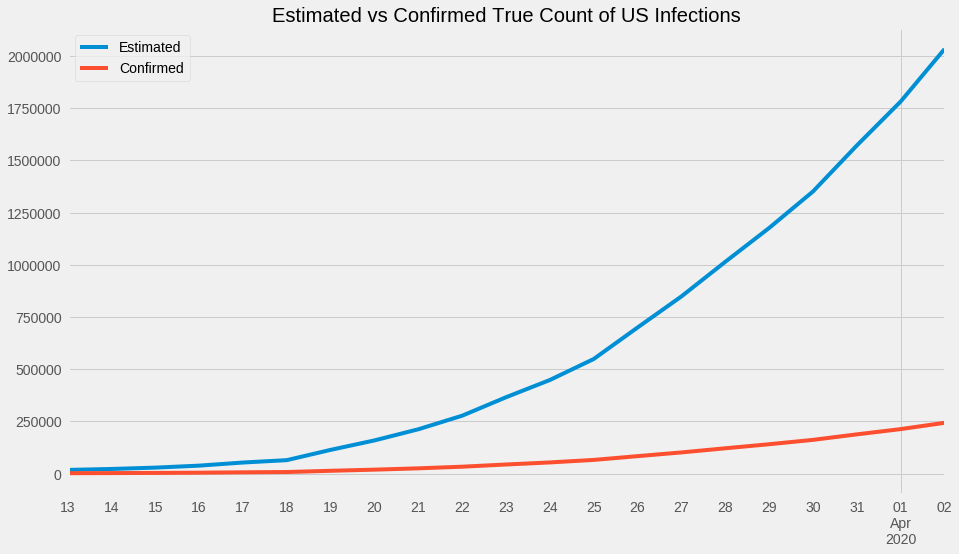

In [99]:
ax = current_est_us_total.iloc[-21:].plot(figsize=[14,8], 
  title='Estimated vs Confirmed True Count of US Infections',
                                         label='Estimated')
df_cases_country.loc['US']['confirmed'].iloc[-21:].plot(ax=ax, label='Confirmed')
ax.set_xlabel('')
ax.legend()
_ = ax.set_yticklabels(['{:.0f}'.format(x) for x in ax.get_yticks()])

In [43]:
df_cases_country.loc['US']['confirmed'].iloc[-1]

140886.0

In [44]:
shifted_us_deaths = current_us_deaths.shift(-14)
shifted_est_us_mort_rt = shifted_us_deaths / current_est_us_total
print("The implied US mortality rate would be {:.2%}".format(shifted_est_us_mort_rt.dropna().sort_index().iloc[-1]))

The implied US mortality rate would be 8.54%


As of Fri Mar 6, this rate registers over 24%. That is not supportable from any existing study. I will leave this estimation in the code because it is likely to become more accurate as more data becomes available. It is likely overstated due to undertesting in the US two weeks ago, suggesting that we had far more cases in mid-February than we thought: 
 - 10x more cases if you assume a mortality rate of 2.4%, 
 - 50x more cases if you assume a mortality rate of 0.5%.

In [45]:
current_us_deaths.tail()

dt
2020-03-25     942.0
2020-03-26    1209.0
2020-03-27    1581.0
2020-03-28    2026.0
2020-03-29    2467.0
Name: deaths, dtype: float64

## Future Implications
We can use basic assumptions about the spread rate (r0) and the serial interval (SI) to estimate the magnitude of the spread in each country over the next few months. The best estimates I've found for these metrics come from a study based on the Diamond Princess cruise. See Bibliography.

These two metrics essentially give us the rate of increase for our projection. Though the r0 can be reduced over time by competent government action (e.g. quarantines), good hygiene (e.g. handwashing), and social distancing measures.

In [46]:
r0 = 2.1 #Each person spreads the virus to 2.1 people
ser_int = 4.7 #Days from infection to transmission


## SIR Epidemiology Model
This model is based on the SIR model, which traces its history back to the early 20th century. It takes into account reductions in the susceptible population as they either gain immunity or die. This makes the model useful for long term predictions.

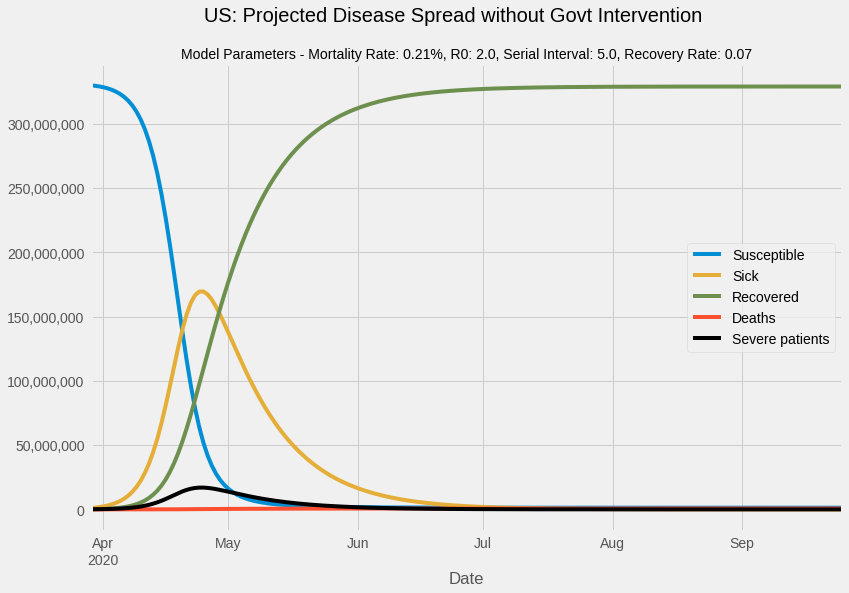

ValueError: zero-size array to reduction operation fmin which has no identity

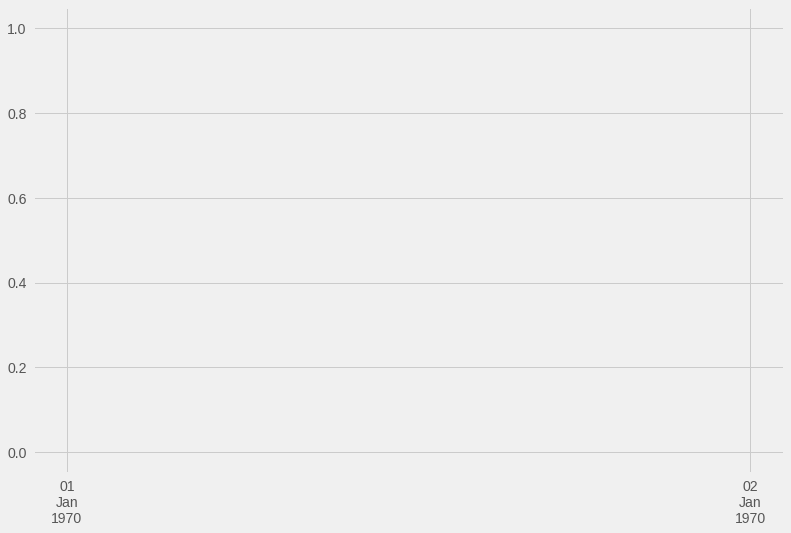

In [47]:
def km_model(init_vals, params, t, seasonality=False):
    suspop_0, infected_0, recovered_0, deaths_0, last_obs_dt = init_vals
    tot_pop = suspop_0 + infected_0 + recovered_0 + deaths_0
    suspop, infected, recovered, deaths = [suspop_0], [infected_0], [recovered_0], [deaths_0]
    l, r0, mort_rt, ser_int = params ## [mean recovery/death rate, mean infection rate]
    k = r0 / (suspop_0 + infected_0 + recovered_0 + deaths_0) * (1/ser_int) * (1-l)
#     k = r0 / tot_pop * l
    
    for t_ in t[:-1]:
        if seasonality:
            thisdate = last_obs_dt + pd.Timedelta(days=t_)
            if thisdate >= pd.Timestamp('2020-05-01') and thisdate <= pd.Timestamp('2020-09-15'):
                r0 = r0/5
            else:
                r0 = params[1]
            k = r0 / (suspop_0 + infected_0 + recovered_0 + deaths_0) * (1/ser_int) * (1-l)
                
        new_infected = min(k * suspop[-1] * infected[-1], suspop[-1])
        new_resolved = l * infected[-1]
        next_suspop = suspop[-1] - new_infected
        next_infected = infected[-1] + (new_infected - new_resolved)
        next_recovered = recovered[-1] + ( new_resolved * (1 - mort_rt) )
        next_deaths = deaths[-1] + ( new_resolved * mort_rt )
        suspop.append(next_suspop)
        infected.append(next_infected)
        recovered.append(next_recovered)
        deaths.append(next_deaths)
        
    df_out = pd.DataFrame(np.stack([suspop, infected, recovered, deaths]).T,
                         index = pd.date_range(last_obs_dt, 
                                               last_obs_dt + pd.Timedelta(days=t.shape[0]-1)),
                         columns = ['suspop', 'infected', 'recovered', 'deaths'])
        
    return df_out

def sir_chart_1axis(km_results, params,start_chart_dt=False,end_chart_dt=False):
    if start_chart_dt or end_chart_dt:
        km_results = km_results.loc[start_chart_dt:end_chart_dt]
    l, r0, mort_rt, ser_int = params
        
    label_dict = {'suspop': ('Susceptible','#008fd5'),
                  'infected': ('Sick','#e5ae38'),
                  'recovered': ('Recovered','#6d904f'),
                  'deaths': ('Deaths','#fc4f30'),
                  'severe': ('Severe patients','black')}
    legend_labels = [label_dict[col][0] for col in km_results.columns]
    linecolors = [label_dict[col][1] for col in km_results.columns]
    
    ax = km_results.plot(figsize=(12,8), color=linecolors)
    plt.suptitle('US: Projected Disease Spread without Govt Intervention', size=20)
    plt.title('Model Parameters - Mortality Rate: {0:.2%}, R0: {1:.1f}, Serial Interval: {2:.1f}, Recovery Rate: {3:.2f}'\
              .format(params[2],params[1],params[3],params[0]), size='medium')
    plt.legend(legend_labels, loc='best')
    
    plt.xlabel('Date')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()
    return

def sir_chart_2axis(km_results, params, start_chart_dt=False,end_chart_dt=False):
    if start_chart_dt or end_chart_dt:
        km_results = km_results.loc[start_chart_dt:end_chart_dt]
    l, r0, mort_rt, ser_int = params
        
    max_vals = km_results.max()
    mask = max_vals.le(max_vals.max()/10)
    right_idx = max_vals[mask].index
    left_idx = [col for col in km_results.columns if col not in right_idx]
    
    label_dict = {'suspop': ('Susceptible','#008fd5'),
                  'infected': ('Sick','#e5ae38'),
                  'recovered': ('Recovered','#6d904f'),
                  'deaths': ('Deaths','#fc4f30')}
    legend_labels = [label_dict[col][0] for col in left_idx]
    linecolors = [label_dict[col][1] for col in left_idx]
        
    ax = km_results[left_idx].plot(figsize=(12,8), color=linecolors)
    plt.suptitle('US: Projected Disease Spread without Govt Intervention', size=20)
    plt.title('Model Parameters - Mortality Rate: {0:.2%}, R0: {1:.1f}, Serial Interval: {2:.1f}, Recovery Rate: {3:.2f}'\
              .format(params[2],params[1],params[3],params[0]), size='medium')
    plt.legend(legend_labels, loc='upper left', title="Left axis")
    plt.xlabel('Date')

    ax2 = ax.twinx()
    
    legend_labels = [label_dict[col][0] for col in right_idx]
    linecolors = [label_dict[col][1] for col in right_idx]
    km_results[right_idx].plot(ax=ax2, color=linecolors, legend=True)

    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_ylim([0, ax.axes.get_yticks().max()])
    ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
    ax2.set_ylim([0, ax2.axes.get_yticks().max()])
    ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
    
    plt.legend(legend_labels, loc='lower right', title="Right axis")

    plt.show()
    return

def death_chart(km_results, params, start_chart_dt=False,end_chart_dt=False):
    ax = km_results[['deaths']].plot(figsize=(12,8), color='#fc4f30', legend=False)
    plt.suptitle('US: Projected Deaths from COVID-19 without Govt Intervention', size=20)
    plt.title('Model Parameters - Mortality Rate: {0:.2%}, R0: {1:.1f}, Serial Interval: {2:.1f}, Recovery Rate: {3:.2f}'\
              .format(params[2],params[1],params[3],params[0]), size='medium')
    plt.xlabel('Date')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()
    return

## Initial Values ##
total_population = 3.3e8
infected = current_est_us_undetected.sort_index().iloc[-1]
recovered = 0.0
deaths = df_cases_country.loc['US', 'deaths'].sort_index().iloc[-1]
last_obs_dt = current_est_us_undetected.index[-1]
init_vals = [total_population, infected, recovered, deaths, last_obs_dt] ## [suceptible pop, infected, recovered/dead]

## Parameters ##
recovery_rate = 1/14
r0 = 2.
ser_int = 5
mort_rt = current_est_us_mort_rt.sort_index().iloc[-1]
params = [recovery_rate, r0, mort_rt, ser_int]

t_max = 180
t = np.linspace(0, t_max, t_max+1)
km_results_best = km_model(init_vals, params, t, seasonality=False)
km_results_best['severe'] = km_results_best.infected*.1

# Plot results
sir_chart_1axis(km_results_best, params)
sir_chart_2axis(km_results_best[['infected', 'recovered','deaths']],params,'2020-03-07','2020-03-21')
sir_chart_2axis(km_results_best[['infected', 'recovered','deaths']],params,'2020-02-14','2020-04-01')
sir_chart_2axis(km_results_best[['infected', 'recovered','deaths']],params,'2020-02-14','2020-05-01')
death_chart(km_results_best, params)


## Multiple Scenarios

In [ ]:
def calc_mort_rt(df_cases_country, mild_case_rate, asymp_rt, mild_asymp_det_rt, severe_det_rt):
    mild_asympt_rate = (mild_case_rate*(1-asymp_rt))+asymp_rt
    
    severe_critical_rate = 1.0-mild_asympt_rate
    
    overall_detection_rate = severe_det_rt*severe_critical_rate + mild_asymp_det_rt*mild_asympt_rate
    
    est_us_cases = ( float(df_cases_country.loc['US','confirmed'].sort_index().iloc[-1]) / 
        overall_detection_rate )
    
    current_est_us_mort_rt = df_cases_country.loc['US','deaths'].sort_index().iloc[-1] / est_us_cases
    
#     print('mild asympt rate: {:.1%}'.format(mild_asympt_rate))
#     print('severe rate: {:.1%}'.format(severe_critical_rate))
#     print('overall_detection_rate: {:.1%}'.format(overall_detection_rate))
    
    return current_est_us_mort_rt

In [ ]:
## Initial Values ##
total_population = 3.3e8
infected = current_est_us_undetected.iloc[-1]
recovered = df_cases_country.loc['US', 'recovered'].iloc[-1]
deaths = df_cases_country.loc['US', 'deaths'].iloc[-1]
last_obs_dt = current_est_us_undetected.index[-1]
init_vals = [total_population, infected, recovered, deaths, last_obs_dt] ## [suceptible pop, infected, recovered/dead]
t_max = 180
t = np.linspace(0, t_max, t_max+1)

n_scenarios = 50
df_scenarios = pd.DataFrame()
df_params = pd.DataFrame()

## Parameters ##
for iter in range(n_scenarios):
    rand_r0 = np.random.gamma(r0*2,1/2)
    rand_si = np.random.normal(ser_int, (4.4-2.9)/1.96)
    rand_asymp_rt = np.random.beta((113/16),(634-113)/16)
    rand_mild_asymp_det_rt = np.random.beta(1,2)
    rand_severe_det_rt = np.random.beta(deaths,1)
    rand_mort_rt = calc_mort_rt(df_cases_country, 0.81, rand_asymp_rt, 
                                rand_mild_asymp_det_rt, rand_severe_det_rt)
    days_to_recovery = np.random.normal(21, np.std([14,21,28]))
    rand_recov_rt = 1/days_to_recovery
#     rand_mort_rt = max(0, np.random.normal(current_est_us_mort_rt.sort_index().iloc[-1], 
#                                            current_est_us_mort_rt[current_est_us_mort_rt.gt(0)].std(), 1)[0])
    params = [rand_recov_rt,rand_r0,rand_mort_rt,rand_si]
    
    df_params[iter] = pd.Series([rand_recov_rt, rand_r0, rand_asymp_rt, rand_mild_asymp_det_rt,
                                 rand_severe_det_rt, rand_mort_rt, rand_si],
                                index = ['rand_recov_rt', 'rand_r0', 'rand_asymp_rt', 
                                         'rand_mild_asymp_det_rt', 'rand_severe_det_rt', 
                                         'rand_mort_rt', 'rand_si'])
    
    km_results = km_model(init_vals, params, t)
    km_results['severe'] = km_results.infected*.1
    df_scenarios[iter] = km_results.stack()

df_scenarios = df_scenarios.unstack(1).swaplevel(axis=1).sort_index(1).sort_index(0)


for var in km_results.columns:
    label_dict = {'suspop': ('Susceptible','#008fd5'),
                  'infected': ('Sick','#e5ae38'),
                  'recovered': ('Recovered','#6d904f'),
                  'deaths': ('Deaths','#fc4f30'),
                  'severe': ('Severe patients','black')}
    legend_labels = label_dict[var][0]
    linecolors = [label_dict[var][1]]
    
    df_chart = df_scenarios[var]
    ax = km_results_best[var].plot(legend=True, label='Original Model', color=linecolors)
    df_chart.plot(alpha=.06, legend=True, figsize=(12,8), label='_nolegend_', ax=ax)
    km_results_best[var].plot(color=linecolors, ax=ax)

    plt.suptitle('US: Projected {0} Population without Govt Intervention'.format(legend_labels), size=20)
    plt.title('Lines Represent Output from {} model runs'.format(n_scenarios), size='medium')
    plt.legend(['Original Model'],loc='upper right', title='Legend')
    
    plt.xlabel('Date')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()

In [ ]:
df_param_summary = pd.DataFrame()
df_param_summary['param_medians'] = df_params.median(1)
df_param_summary['param_means'] = df_params.mean(1)
df_param_summary['param_stds'] = df_params.std(1)
df_param_summary

In [ ]:
df_scen_summary = pd.DataFrame()
df_end_of_scenarios = df_scenarios.iloc[[-1]].stack(1)
df_end_of_scenarios['mort_rt'] = df_end_of_scenarios['deaths'] / df_end_of_scenarios.sum(axis=1)
df_end_of_scenarios['infected_rt'] = 1 - (df_end_of_scenarios['suspop'] / df_end_of_scenarios.sum(axis=1))

df_scen_summary['scen_medians'] = df_end_of_scenarios.median()
df_scen_summary['scen_means'] = df_end_of_scenarios.mean()
df_scen_summary['scen_stds'] = df_end_of_scenarios.std()
df_scen_summary


In [ ]:
dt_max_infected = df_scenarios['infected'].apply(lambda x: x.idxmax(), axis=0).sort_values()
percentile = 0.05
tail_date = dt_max_infected.iloc[-int(n_scenarios*percentile)]
avg_max_in_tail = df_scenarios['infected'].T.loc[dt_max_infected.ge(tail_date)].max(1).mean()
print('{:.0%} of simulations have a peak infection date later than {}'.format(percentile, tail_date))
print('Of those simulations, they peak at an average of {:,.0f}'.format(avg_max_in_tail))

In [ ]:
df_scenarios['deaths'].sort_index().iloc[-1].describe()

In [ ]:
dt_max_deaths = df_scenarios[['deaths']].apply(lambda x: x.max())
dt_max_deaths.describe()

In [ ]:
dt_max_deaths.quantile(.05)

In [ ]:
# dt_max_deaths = df_scenarios['deaths'].sort_index()
# percentile = 0.05
# tail_date = dt_max_deaths.iloc[-int(n_scenarios*percentile)]
# avg_max_in_tail = df_scenarios['infected'].T.loc[dt_max_deaths.ge(tail_date)].max(1).mean()
# print('{:.0%} of simulations have a peak infection date later than {}'.format(percentile, tail_date))
# print('Of those simulations, they peak at an average of {:,.0f}'.format(avg_max_in_tail))

## Seasonality

In [ ]:
## Initial Values ##
total_population = 3.3e8
infected = current_est_us_undetected.sort_index().iloc[-1]
recovered = 0.0
deaths = df_cases_country.loc['US', 'deaths'].sort_index().iloc[-1]
last_obs_dt = current_est_us_undetected.index[-1]
init_vals = [total_population, infected, recovered, deaths, last_obs_dt] ## [suceptible pop, infected, recovered/dead]

## Parameters ##
recovery_rate = 1/14
r0 = 2.1
ser_int = 7
mort_rt = current_est_us_mort_rt.sort_index().iloc[-1]
params = [recovery_rate, r0, mort_rt, ser_int]

t_max = 500
t = np.linspace(0, t_max, t_max+1)
km_results_seasonal = km_model(init_vals, params, t, seasonality=True)

# Plot results
sir_chart_1axis(km_results_seasonal, params)
sir_chart_2axis(km_results_seasonal[['infected', 'recovered','deaths']],params,'2020-03-07','2020-03-21')
sir_chart_2axis(km_results_seasonal[['infected', 'recovered','deaths']],params,'2020-02-14','2020-04-01')
death_chart(km_results_seasonal, params)

# State/City Models

In [ ]:
df_us = df_cases.loc['US'].reset_index()
dt_for_pie_chart = df_us['dt'].max()
df_us = df_us[df_us.dt==dt_for_pie_chart]
df_us = df_us.groupby('province').sum()
df_us = df_us[df_us.sum(axis=1)>0]

df_us_agg = df_us.loc[df_us.sort_values('confirmed', ascending=False).index[:5]]
df_us_agg.loc['Other States'] = df_us.loc[df_us.sort_values('confirmed', ascending=False).index[5:]].sum()

display(df_us_agg['confirmed'])
df_us_agg['confirmed'].plot.pie(title='Confirmed COVID-19 Infections by State\nAs of {}'.format(
    dt_for_pie_chart.strftime("%d %b, %Y")), label="")


## LA Model

In [ ]:
# [x for x in df_cases.loc['US'].index.levels[0] if 'CA' in x]
# df_cases.loc[('US','CA'),'confirmed'].plot()
la_msa_pop = 13.3e6
la_curr_rep_cases = 351. #just LA County on 3/22
la_curr_rep_hosp_rt = .2
la_detection_rt_est = 0.02
la_curr_hosp_cases_est = la_curr_rep_cases*la_curr_rep_hosp_rt
print('Current estimated hospitalized cases in LA: ',la_curr_hosp_cases_est)
la_total_hosp_beds = 21000
la_bed_occupancy_rt = .67
la_available_beds = la_total_hosp_beds*(1-la_bed_occupancy_rt)
print('Current estimated open beds in LA: ',la_available_beds)
la_eight_days_back = '2020-03-14'
la_recovered = 5.
t_max = 180
t = np.linspace(0, t_max, t_max+1)

In [ ]:
# df_test_la_allcols = km_model([la_msa_pop, la_curr_hosp_cases_est/.10, 
#                             la_recovered, 10, pd.Timestamp(la_eight_days_back)]
#                             , [0.05,1.33,0.002,5.0], t, seasonality=False)
df_test_la_allcols = km_model([la_msa_pop, la_curr_rep_cases/la_detection_rt_est, 
                            la_recovered, 10, pd.Timestamp('2020-03-22')]
                            , [0.05,.5,0.002,5.0], t, seasonality=False)
df_test_la = df_test_la_allcols['infected']
ax = df_test_la.loc[:'2020-06-30'].plot(title='Projected laC Cases vs Total Testing',
                    label="Forecasted Total Infections in laC Region",
                                       figsize=[14,8])

df_states.loc['CA','positive'].loc[eight_days_back:].plot(
    ax=ax, label = 'Reported Positive Tests in CA')

# df_la['hospitalized'].shift(-8).dropna().div(.1).plot(ax=ax, label='Hospitalized estimated cases')
ax.legend()

plt.xlabel('Date')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
df_chart = df_test_la.shift(8).mul(.10).loc[la_eight_days_back:'2020-04-14'].dropna()
ax = df_chart.plot(title='Forecast laC COVID-19 Hospitalizations\nWorst Case Scenario as of Mar. 22', 
                   label='Hospitalized', figsize=[14,8])
# df_la['hospitalized'].dropna().plot(ax=ax, label='Reported Hospitalizations', color='y')
ax.hlines(y=la_available_beds, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='r',
          linewidth=2, label = 'laC Hospital Bed Capacity Est.')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

print(ax.get_xlim())

from matplotlib.patches import Rectangle
date_we_can_effect = ((pd.Timestamp.today() + pd.Timedelta('7d')
                       - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')) 

rect = Rectangle((date_we_can_effect,0),10,ax.get_ylim()[1]*2, 
                 linewidth=0,facecolor='black', alpha=.2)
# Add the patch to the Axes
ax.add_patch(rect)
ax.text(date_we_can_effect, ax.get_ylim()[1]*.8,'Our Actions Now\nCan Slow This',
       size=25)


print('totals')
display(df_chart.loc[la_eight_days_back:].dropna())
print('change')
display(df_chart.loc[la_eight_days_back:].diff().dropna())

## NYC Model

In [ ]:
nycounties = [thing for thing in df_cases.loc['US'].index.levels[0] if ', NY' in thing]


df_ny = df_cases.loc['US'].loc[nycounties+['New York']]
df_ny = df_ny.reset_index().groupby('dt').sum().loc['2020-03-01':]
df_ny.tail()

In [ ]:
#Manually Enter Current NYC Number
# https://coronavirus.health.ny.gov/county-county-breakdown-positive-cases
# df_ny.loc[pd.Timestamp('2020-03-19')]=4152.0
last_ny_dt = '2020-03-23'
last_ny_confirmed = 20875.0
if pd.Timestamp(last_ny_dt) not in df_cases.loc['US'].loc[nycounties+['New York']].index:
    df_ny.loc[pd.Timestamp(last_ny_dt)]=df_ny.loc[pd.Timestamp(last_ny_dt)-pd.Timedelta(days=1)]
    df_ny.loc[pd.Timestamp(last_ny_dt),'confirmed']=last_ny_confirmed
    df_ny.loc[pd.Timestamp(last_ny_dt),'outstanding'] = (df_ny.loc[pd.Timestamp(last_ny_dt),'outstanding']
                                                         + (df_ny.confirmed.iloc[-1] - df_ny.confirmed.iloc[-2])) 
    print('Adding manual entry to JHU data')
    display(df_ny.tail())
else:
    print('JHU data up to date')

In [ ]:
ax = df_ny['confirmed'].plot(title='Current Detected NY COVID-19 Cases')
ax.set_xlabel('')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
ax = df_ny['confirmed'].diff().plot(title='Day-to-Day Change in Detected NYS COVID-19 Cases')
ax.set_xlabel('')
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
# Update Detection Rate
# https://nymag.com/intelligencer/2020/03/new-york-coronavirus-cases-updates.html
# ny_curr_hospitalized = 777.0 #As of Mar 19
# ny_curr_hospitalized = 1255.0 #As of Mar 20
# ny_curr_hospitalized = 1603.0 #As of Mar 21
df_ny['hospitalized'] = pd.Series([153., 331., 549., 777.,1255.,1603.,1974., 2635., 3234., 3805.], 
                                  index=pd.date_range('2020-03-15','2020-03-24'))
df_ny['nyc_hospitalized'] = pd.Series([113.0, 238.0, 380.0, 554.0, 914.0, 1161.0, 1400.0, 1872.0],
                                     index=pd.date_range('2020-03-16','2020-03-23'))
ny_curr_hospitalized = df_ny['hospitalized'].iloc[-1]
eight_days_back = df_ny['hospitalized'].index[-9]
print('eight days back: ',eight_days_back)
print('current hospitalizations: ', ny_curr_hospitalized)


In [ ]:
# So take the number from 8 days ago (Mar 18) divide it by the severity rate (4.4%-9% or avg 6.7%)
ny_implied_8daylag_hiscen = ny_curr_hospitalized/.044
ny_implied_8daylag_lowscen = ny_curr_hospitalized/0.133
print('NY cases on {} using 4.4% hosp rate'.format(eight_days_back), ny_implied_8daylag_hiscen)
print('NY cases on {} using 10% hosp rate'.format(eight_days_back), ny_curr_hospitalized/.1)
print('NY cases on {} using 13% hosp rate'.format(eight_days_back), ny_implied_8daylag_lowscen)
print('current hospitalizations: ', ny_curr_hospitalized)
print("NY confirmed cases a week ago", df_ny.loc[eight_days_back,'confirmed'])
ny_detection_rate_hiscen = df_ny.loc[eight_days_back,'confirmed']/ny_implied_8daylag_hiscen
ny_detection_rate_lowscen = df_ny.loc[eight_days_back,'confirmed']/ny_implied_8daylag_lowscen
print('hi scenario det rate: ', ny_detection_rate_hiscen)
print('low scenario det rate: ', ny_detection_rate_lowscen)
print('NY today: ',df_ny.iloc[-1]['confirmed'])
# print('200/8000: ',200/8000.0)
# print('220/7770: ',220/7770.0)
# print('1:40 cases detected')

In [ ]:
def reported_to_est_inf(curr_rep_lvl, mild_case_rate,
                       asympt_rate, nonsev_det_rate,
                       sev_det_rate, overall_detection_rate=False):
    if not overall_detection_rate:
        nonsevere_rt = (mild_case_rate/(1-asympt_rate_est))/(1+asympt_rate_est) ## Mild & Asymptomatic Rate
        print("nonsevere rate: ",nonsevere_rt)
        severe_rt = 1-nonsevere_rt ## Severe & Critical Rate
        print("severe rate: ", severe_rt)
        overall_detection_rate = (sev_det_rate*severe_rt 
                                  + nonsev_det_rate*nonsevere_rt)
    print("overall detection rate: ",overall_detection_rate)
    infected = curr_rep_lvl/overall_detection_rate
    return infected

In [ ]:
ny_days_ago_start_model = -1

In [ ]:
reported_to_est_inf(df_ny['outstanding'].iloc[
    ny_days_ago_start_model], .85, .4, .005, .5,ny_detection_rate_lowscen)

In [ ]:
# df_states = df_states.set_index('date')
# df_states[df_states.state=='NY']['total'].cumsum().plot()


In [ ]:
nyc_curr_low = reported_to_est_inf(df_ny['outstanding'].iloc[
    ny_days_ago_start_model], 
                                            .8, .17, .25, .9)
nyc_curr_high = reported_to_est_inf(df_ny['outstanding'].iloc[
ny_days_ago_start_model], 
                                             .8, .35, .1, .8)

nyc_curr_newlow = reported_to_est_inf(df_ny['outstanding'].iloc[
    ny_days_ago_start_model], 
                                            1, 1, 1, 1,ny_detection_rate_lowscen)
nyc_curr_newhigh = reported_to_est_inf(df_ny['outstanding'].iloc[
ny_days_ago_start_model], 
                                             1, 1, 1, 1,ny_detection_rate_hiscen)

df_ny_curr = pd.DataFrame()
df_ny_curr['Estimate'] = pd.Series(['Reported','Prev. Low Estimate Method', 
                                    'Prev. High Estimate Method',
                                    'Data-Calibrated Detection Rates - Low',
                                    'Data-Calibrated Detection Rates - High'
                                   ])
df_ny_curr['Infected'] = pd.Series([df_ny['outstanding'].iloc[ny_days_ago_start_model],
                                    nyc_curr_low, nyc_curr_high,
                                    nyc_curr_newlow, nyc_curr_newhigh
])
df_ny_curr = df_ny_curr.set_index('Estimate')
df_ny_curr

In [ ]:
ax = df_ny_curr.plot.bar(
    title = 'Currently Estimated NYC-region COVID-19 Infections\nas of {}'.format(
        df_ny['outstanding'].index[
    ny_days_ago_start_model].strftime("%d %b, %Y")),
legend= False)
ax.xaxis.set_label_text("")

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+.04, i.get_height()+20, \
            "{:,.0f}".format((i.get_height())), fontsize=20,
                color='dimgrey', rotation=0)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
df_ny_curr #.loc['High Estimate','Infected']

In [ ]:
## Initial NYC Values ##
total_population = 8e6
recovered = 0.0
deaths = df_ny['deaths'].sort_index().iloc[ny_days_ago_start_model]
last_obs_dt = df_ny.index[ny_days_ago_start_model]

## Parameters ##
recovery_rate = 1/21
r0 = 2.
ser_int = 5
mort_rt = current_est_us_mort_rt.sort_index().iloc[ny_days_ago_start_model]
params = [recovery_rate, r0, mort_rt, ser_int]
# severity

t_max = 180
t = np.linspace(0, t_max, t_max+1)
df_ny_low_start = km_model([total_population, 
                            df_ny_curr.loc['Prev. Low Estimate Method','Infected'], 
                            recovered, deaths, last_obs_dt]
                            , params, t, seasonality=False)
df_ny_low_start['severe'] = df_ny_low_start.infected*.1

df_ny_high_start = km_model([total_population, 
                            df_ny_curr.loc['Prev. High Estimate Method','Infected'], 
                            recovered, deaths, last_obs_dt]
                            , params, t, seasonality=False)
df_ny_high_start['severe'] = df_ny_high_start.infected*.1
df_ny_new_low_start = km_model([total_population, 
                            df_ny_curr.loc['Data-Calibrated Detection Rates - Low','Infected'], 
                            recovered, deaths, last_obs_dt]
                            , params, t, seasonality=False)
df_ny_new_low_start['severe'] = df_ny_new_low_start.infected*.1

df_ny_new_high_start = km_model([total_population, 
                            df_ny_curr.loc['Data-Calibrated Detection Rates - High','Infected'], 
                            recovered, deaths, last_obs_dt]
                            , params, t, seasonality=False)
df_ny_new_high_start['severe'] = df_ny_new_high_start.infected*.1


In [ ]:
df_ny_low_start.loc[:'2020-04-01','infected'].mul(.33) #.plot()

In [ ]:
df_ny_high_start[df_ny_high_start.severe.ge(3000)].dropna().iloc[[0]]

In [ ]:
df_ny_high_start[df_ny_high_start.severe.ge(3000)].dropna().iloc[[0]]

In [ ]:
df_ny_low_start.severe.iloc[:1]

In [ ]:
df_ny_low_start[df_ny_low_start.severe.ge(3000)].dropna().iloc[[0]]

In [ ]:
df_ny_new_low_start[df_ny_new_low_start.severe.ge(3000)].dropna()['severe'].head(15)

In [ ]:
df_ny_new_low_start[df_ny_new_low_start.severe.ge(3000)].dropna()['severe'].diff().head(15)

In [ ]:
df_ny_new_low_start.infected.pct_change().head(5)

In [ ]:
df_ny_new_high_start[df_ny_new_high_start.severe.ge(3000)].dropna().iloc[[0]]

In [ ]:
# df_ny_high_start[df_ny_high_start.index.isin(mydates)][['infected']]

In [ ]:
mydates = ['2020-03-11','2020-03-18','2020-03-23', '2020-03-25','2020-03-28']
# mydates = ['2020-03-19','2020-03-24','2020-03-29']
nyc_hosp_bed_low = 1200.
nyc_hosp_bed_high = 3000.
nyc_hosp_bed_mayor = 8300.
df_ny_chart = df_ny_high_start[df_ny_high_start.index.isin(mydates)][['infected']]
df_ny_chart = df_ny_chart.rename(columns={'infected':'Prev. High Method Starting Estimate'})
df_ny_chart['Prev. Low Method Starting Estimate'] = df_ny_low_start[df_ny_low_start.index.isin(mydates)][['infected']]

df_ny_chart['Data-Calibrated Detection Rates - Low'] = df_ny_new_low_start[df_ny_new_low_start.index.isin(mydates)][['infected']]
df_ny_chart['Data-Calibrated Detection Rates - High'] = df_ny_new_high_start[df_ny_new_high_start.index.isin(mydates)][['infected']]
df_ny_chart = df_ny_chart[[
       'Prev. Low Method Starting Estimate','Prev. High Method Starting Estimate',
       'Data-Calibrated Detection Rates - Low',
       'Data-Calibrated Detection Rates - High']]
# df_ny_chart = df_ny_chart.rename(columns={
#     'Low Starting Estimate':'Low Starting Estimate ({:,.0f})'.format(
#         df_ny_chart['Low Starting Estimate'].iloc[0]),
#     'High Starting Estimate':'High Starting Estimate ({:,.0f})'.format(
#         df_ny_chart['High Starting Estimate'].iloc[0])
# })
df_ny_chart

In [ ]:
df_ny_chart.columns

In [ ]:
ax = df_ny_chart.plot.bar(title="Near Term For NYC Region\nCOVID-19 Overall Infections")
xtl=[item.get_text()[:10] for item in ax.get_xticklabels()]
_=ax.set_xticklabels(xtl)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            "{:,.0f}".format((i.get_height())), fontsize=15,
                color='dimgrey', rotation=60)
    
plt.xlabel('Date')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0,ax.get_ylim()[1]*1.1])
ax.legend(loc='upper left')

In [ ]:
ax = df_ny_chart.mul(.1).plot.bar(#color=['g','y'],
    title="Near Term For NYC Region COVID-19 \nSevere Cases Requiring Medical Attention")
xtl=[item.get_text()[:10] for item in ax.get_xticklabels()]
_=ax.set_xticklabels(xtl)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            "{:,.0f}".format((i.get_height())), fontsize=15,
                color='dimgrey', rotation=60)
ax.hlines(y=nyc_hosp_bed_low, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='r',linewidth=2,
             label = 'NYC Hospital Bed Capacity - Low Est.')
ax.hlines(y=nyc_hosp_bed_high, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='purple', linewidth=2,
             label = 'NYC Hospital Bed Capacity - High Est.')
plt.xlabel('Date')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0,ax.get_ylim()[1]*1.1])
ax.legend(loc='upper left')

In [ ]:
lagged_date = pd.date_range(df_ny_low_start.index[0]- pd.Timedelta(days=7),
              df_ny_low_start.index[-1]- pd.Timedelta(days=7)
             )
test = df_ny_low_start['severe'].copy()
test.index = lagged_date
test.plot()


In [ ]:
ax = df_ny_chart.mul(.1).plot.bar(color=['g','y'],
    title="Near Term For NYC Region COVID-19 \nSevere Cases Requiring Medical Attention")
xtl=[item.get_text()[:10] for item in ax.get_xticklabels()]
_=ax.set_xticklabels(xtl)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.03, i.get_height()+.5, \
            "{:,.0f}".format((i.get_height())), fontsize=15,
                color='dimgrey', rotation=30)
ax.hlines(y=nyc_hosp_bed_low, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='r',linewidth=2,
             label = 'NYC Hospital Bed Capacity - Low Est.')
ax.hlines(y=nyc_hosp_bed_high, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='purple', linewidth=2,
             label = 'NYC Hospital Bed Capacity - High Est.')
plt.xlabel('Date')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0,ax.get_ylim()[1]*1.1])
ax.legend(loc='upper left')

In [ ]:
params

In [ ]:
df_states.loc['NY']

## NYC Hospitalization calibrated model

In [ ]:
df_test_ny_allcols = km_model([8e6, ny_curr_hospitalized/.10, 
                            recovered, 10, pd.Timestamp(eight_days_back)]
                            , [0.05,2.0,0.002,5.0], t, seasonality=False)
df_test_ny = df_test_ny_allcols['infected']
ax = df_test_ny.loc[:'2020-03-27'].plot(title='Projected NYC Cases vs Total Testing',
                    label="Forecasted Total Infections in NYC Region",
                                       figsize=[14,8])

df_states.loc['NY','positive'].loc[eight_days_back:].plot(
    ax=ax, label = 'Reported Positive Tests in NY')

df_ny['hospitalized'].shift(-8).dropna().div(.1).plot(ax=ax, label='Hospitalized estimated cases')
ax.legend()

plt.xlabel('Date')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
df_test_ny_allcols.loc['2020-03-20':'2020-03-29'].diff()

In [ ]:
df_test_ny_allcols.head() #.loc[:'2020-04-03']

In [ ]:
df_ny['hospitalized'].dropna()

In [ ]:
df_chart = df_test_ny.shift(8).mul(.10).loc[eight_days_back:'2020-04-02'].dropna()
ax = df_chart.plot(title='Forecast NYC COVID-19 Hospitalizations\nWorst Case Scenario as of {}'.format(
df_ny['hospitalized'].index[-1].strftime("%b %d %y")), 
                   label='Hospitalized', figsize=[14,8])
df_ny['hospitalized'].dropna().plot(ax=ax, label='Reported Hospitalizations', color='y')
ax.hlines(y=nyc_hosp_bed_low, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='r',
          linewidth=2, label = 'NYC Hospital Bed Capacity - Low Est.')
ax.hlines(y=nyc_hosp_bed_high, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='purple',
          linewidth=2, label = 'NYC Hospital Bed Capacity - High Est.')
ax.hlines(y=nyc_hosp_bed_mayor, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='g',
          linewidth=2, label = 'NYC Hospital Bed Capacity - Mayor\'s Est.')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend()

print(ax.get_xlim())

from matplotlib.patches import Rectangle
date_we_can_effect = ((pd.Timestamp.today() + pd.Timedelta('7d')
                       - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')) 

rect = Rectangle((date_we_can_effect,0),10,ax.get_ylim()[1]*2, 
                 linewidth=0,facecolor='black', alpha=.2)
# Add the patch to the Axes
ax.add_patch(rect)
ax.text(date_we_can_effect, ax.get_ylim()[1]*.8,'Our Actions Now\nCan Slow This',
       size=25)


print('totals')
display(df_chart.loc[eight_days_back:].dropna())
print('change')
display(df_chart.loc[eight_days_back:].diff().dropna())

In [ ]:
print('new hospital cases CREATED on this day, arriving 8 days later')
df_test_ny.mul(.10).dropna().diff()

In [ ]:
df_states.loc['NY','total'].plot(title='Cumulative NY Tests Performed') # total is already the cumsum

In [ ]:
df_states.loc['NY','positive'].plot(title='Cumulative NY Positive Tests')
# df_test_ny

In [ ]:
df_chart = df_states.loc['NY','positive'].div(df_test_ny).loc['2020-03-11':].dropna()
ax = df_chart.plot(title='NYC Detection Rate Over Time')
display(df_chart)
_ = ax.set_yticklabels(['{:.1%}'.format(x) for x in ax.get_yticks()])

In [ ]:
# df_states.loc['NY','positive']
df_test_ny.head(10)

In [ ]:
display(df_states.loc['NY','positive'].div(df_test_ny).dropna().tail())
last_ny_det_rt = df_states.loc['NY','positive'].div(df_test_ny).dropna().iloc[-1]
print(last_ny_det_rt)

In [ ]:
df_test_ny = km_model([total_population, 770/.1, 
                       recovered, deaths, pd.Timestamp('2020-03-09')]
                      , [0.05,2.0,0.002,4.7], t, seasonality=False)['infected'
                                                                   ].loc[:'2020-03-25']
df_test_ny.plot()
df_states.loc['NY','total'].plot()

In [ ]:
## Initial Values ##
n_scenarios = 50
total_population = 23e6
t_max = 100
curr_rep_lvl = df_ny['confirmed'].iloc[-1]
recovered = df_ny['recovered'].iloc[-1]
deaths = df_ny['deaths'].iloc[-1]
last_obs_dt = df_ny.index[-1]
init_vals = [total_population, infected, recovered, deaths, last_obs_dt] ## [suceptible pop, infected, recovered/dead]
nonsev_det_rt =0.5

t = np.linspace(0, t_max, t_max+1)


nonsevere_rt = (mild_case_rate/(1-asympt_rate_est))/(1+asympt_rate_est) ## Mild & Asymptomatic Rate
severe_rt = 1-nonsevere_rt ## Severe & Critical Rate
overall_detection_rate = detection_rate_severe_cases*severe_rt + nonsev_det_rt*nonsevere_rt
infected = curr_rep_lvl/overall_detection_rate
print("current estimated infection levels", infected)
df_ny_scenarios = pd.DataFrame()
df_ny_params = pd.DataFrame()

## Parameters ##
for iter in range(n_scenarios):
    rand_r0 = np.random.gamma(r0*2,1/2)
    rand_si = np.random.normal(ser_int, (4.4-2.9)/1.96)
    rand_asymp_rt = np.random.beta((113/16),(634-113)/16)
    rand_mild_asymp_det_rt = np.random.beta(1,2)
    rand_severe_det_rt = np.random.beta(22,1)
    rand_mort_rt = np.random.normal(0.6,0.15)
    days_to_recovery = np.random.normal(21, np.std([14,21,28]))
    rand_recov_rt = 1/days_to_recovery
#     rand_mort_rt = max(0, np.random.normal(current_est_us_mort_rt.sort_index().iloc[-1], 
#                                            current_est_us_mort_rt[current_est_us_mort_rt.gt(0)].std(), 1)[0])
    params = [rand_recov_rt,rand_r0,rand_mort_rt,rand_si]
    
    df_ny_params[iter] = pd.Series([rand_recov_rt, rand_r0, rand_asymp_rt, rand_mild_asymp_det_rt,
                                 rand_severe_det_rt, rand_mort_rt, rand_si],
                                index = ['rand_recov_rt', 'rand_r0', 'rand_asymp_rt', 
                                         'rand_mild_asymp_det_rt', 'rand_severe_det_rt', 
                                         'rand_mort_rt', 'rand_si'])
    
    km_ny_results = km_model(init_vals, params, t)
    km_ny_results['severe'] = km_ny_results.infected*.1
    df_ny_scenarios[iter] = km_ny_results.stack()

df_ny_scenarios = df_ny_scenarios.unstack(1).swaplevel(axis=1).sort_index(1).sort_index(0)

In [ ]:
for var in ['infected']: # km_results.columns:
    label_dict = {'suspop': ('Susceptible','#008fd5'),
                  'infected': ('Sick','#e5ae38'),
                  'recovered': ('Recovered','#6d904f'),
                  'deaths': ('Deaths','#fc4f30'),
                  'severe': ('Severe patients','black')}
    legend_labels = label_dict[var][0]
    linecolors = [label_dict[var][1]]
    
    df_chart = df_ny_scenarios[var].loc[:'2020-08-01']*.1
    ax = df_chart.mean(1).plot(legend=True, label='Average of Models', 
                               color='black')
    pd.Series(1200, index=df_chart.index).plot(ax=ax, color='r',
                                                          label='NYC COVID-19 Hospital Bed Capacity')
#     ax.hlines(y=1200, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='r',
#              label = 'NYC Hospital Bed Capacity')
    plt.legend()
    df_chart.plot(alpha=.06, legend=False, figsize=(12,8), ax=ax)

    
#     ax.set_ylim(0,1e4)

    plt.suptitle('NYC: Projected Severely {0} Population without Govt Intervention'.format(legend_labels), size=20)
    plt.title('Lines Represent Output from {} model runs'.format(n_scenarios), size='medium')
#     plt.legend(['Original Model'],loc='upper right', title='Legend')
    
    plt.xlabel('Date')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()

In [ ]:
dt_max_sev = df_ny_scenarios[['severe']].apply(lambda x: x.max())
dt_max_sev.describe()

In [ ]:
dt_max_sev.le(1200).sum()/1000

In [ ]:
df_ny_scenarios['infected'].mean(1).loc['2020-04-02']

In [ ]:
df_ny_scenarios['deaths'].mean(1)[df_ny_scenarios['deaths'].mean(1).ge(1200)].diff().head(12)

# Exponential Forecast Model
NOTE: I made this model. It's parameterized by research-based estimates, but it doesn't directly take into account recovery or reductions in the susceptible population. As a result, this model is only useful for near-term forecasts.

In [ ]:
def coronita_model(curr_rep_lvl, curr_deaths, ## Currently Reported Level
                   asymp_rt, mild_case_rt, mort_rt, ## Disease Factors
                   nonsev_det_rt, sev_det_rt, ## Detection rates
                   basic_r0_si, ## Spread Rates
                   gov_int_lvl, controlled_r0, ## Government Intervention
                   start_date=pd.Timestamp.today(), 
                   end_date=pd.Timestamp.today()+pd.Timedelta(120, unit='days')):
    
    basic_r0, si = basic_r0_si
    
    nonsevere_rt = (mild_case_rt/(1-asympt_rate_est))/(1+asympt_rate_est) ## Mild & Asymptomatic Rate
    severe_rt = 1-nonsevere_rt ## Severe & Critical Rate
    overall_detection_rate = sev_det_rt*severe_rt + nonsev_det_rt*nonsevere_rt
    start_lvl = curr_rep_lvl/overall_detection_rate
    
    ## FIGURE OUT FUNCTION FOR INCREASING DETECTION RATE ##
    
    ## Projection ##
    df_projection = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date))
    df_projection['days_from_now'] = pd.Series(np.linspace(0,
                                                           df_projection.shape[0]-1,
                                                           df_projection.shape[0]),
                                          index=df_projection.index)
    
    ## ADD ABILITY TO CHANGE R0 DUE TO GOV INTERVENTION ##    
    
    df_projection['detection_rate'] = overall_detection_rate
    
    df_projection['proj_cumul_cases'] = (np.power(basic_r0+1,
                                                  (df_projection['days_from_now']/si)
                                                 ) * start_lvl*(1-df_projection['detection_rate']))
    
    df_projection['proj_cumul_cases'] = df_projection['proj_cumul_cases'].clip(lower=0.0)
    
    df_projection['proj_detected_cases'] = (df_projection['proj_cumul_cases'] 
                                            * df_projection['detection_rate'])
    
    df_projection.loc[df_projection['proj_detected_cases']>=gov_int_lvl, 'detection_rate'] = (
        0.99*severe_rt + min(nonsev_det_rt*4,(1-asympt_rate_est/2))*nonsevere_rt)
    
    df_projection['proj_detected_cases'] = (df_projection['proj_cumul_cases'] 
                                            * df_projection['detection_rate'])
    
    df_projection['proj_undetected_cases'] = df_projection['proj_cumul_cases']-df_projection['proj_detected_cases']
    
    df_projection['proj_deaths'] = df_projection['proj_cumul_cases'].shift(7)*mort_rt
#     df_projection['proj_deaths'] = (df_projection['proj_cumul_cases'].diff()*mort_rt+curr_deaths)
#     df_projection['proj_deaths'] = df_projection['proj_deaths'].fillna(curr_deaths)
    
    return df_projection


## Research based parameter estimates

In [ ]:
country = 'US'
df_model_out = coronita_model(curr_rep_lvl=df_cases_country.loc[country].iloc[-7]['confirmed'], 
                              curr_deaths=df_cases_country.loc[country].iloc[-7]['deaths'],
                              asymp_rt=0.3, mild_case_rt=0.8, mort_rt=0.01,
                              nonsev_det_rt=0.05, sev_det_rt=0.9, 
                              basic_r0_si=(2.1,4.4), gov_int_lvl=1e10, controlled_r0=1.1,
                             start_date=df_cases_country.loc[country].iloc[-7].name)

In [ ]:
chart = df_model_out.loc[:'2020-03-17']
ax = chart[['proj_detected_cases','proj_undetected_cases']].plot.area(
    stacked=True, figsize=(12,8), color=['g','b'])

df_cases_country.loc[country].iloc[-7:][['confirmed']].plot(ax=ax)
ax.legend(['Projected Reported Cases','Projected Undetected Cases','Actual US Reported Cases'])

ax2 = ax.twinx()
chart['proj_deaths'].plot(ax=ax2, color='r', legend=True)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0, ax.axes.get_yticks().max()])
ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
ax2.set_ylim([0, ax2.axes.get_yticks().max()])
ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
ax.set_title('Projected US Cases in March without Government Intervention')
_ = plt.legend(['Projected Deaths (Right Axis)'], loc='lower right')


In [ ]:
chart = df_model_out.loc[:'2020-04-30']
ax = chart[['proj_detected_cases','proj_undetected_cases']].plot.area(
    stacked=True, figsize=(12,8), color=['g','b'])
plt.legend(['Projected Detected Cases (Left Axis)', 'Projected Undetected Cases (Left Axis)'])

ax2 = ax.twinx()
chart['proj_deaths'].plot(ax=ax2, color='r', legend=True)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0, ax.axes.get_yticks().max()])
ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
ax2.set_ylim([0, ax2.axes.get_yticks().max()])
ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
ax.set_title('Projected US Cases through April without Government Intervention')
_ = plt.legend(['Projected Deaths (Right Axis)'], loc='lower left')


### Backtest US

In [ ]:
# 'suspop': ('Susceptible','#008fd5'),
#                   'infected': ('Sick','#e5ae38'),
#                   'recovered': ('Recovered','#6d904f'),
#                   'deaths': ('Deaths','#fc4f30'),

In [ ]:
country = 'US'
df_model_out = coronita_model(curr_rep_lvl=df_cases_country.loc[country].iloc[-7]['confirmed'], 
                              curr_deaths=df_cases_country.loc[country].iloc[-7]['deaths'],
                              asymp_rt=0.3, mild_case_rt=0.8, mort_rt=0.01,
                              nonsev_det_rt=0.05, sev_det_rt=0.9, 
                              basic_r0_si=(2.1,4.4), gov_int_lvl=1e10, controlled_r0=1.1,
                             start_date=df_cases_country.loc[country].iloc[-7].name)

chart = df_model_out.loc[:df_cases_country.loc[country].iloc[-7].name + pd.Timedelta(days=10)]
ax = chart[['proj_detected_cases','proj_undetected_cases']].plot.area(
    stacked=True, figsize=(12,8), color=['#e5ae38','#008fd5'])

df_cases_country.loc[country].iloc[-7:][['confirmed']].plot(ax=ax, style=['--'],color=['black'])
ax.legend(['Projected Reported Cases','Projected Undetected Cases',
           'Actual US Reported Cases'])

ax2 = ax.twinx()
chart['proj_deaths'].plot(ax=ax2, color='#fc4f30', legend=True)
df_cases_country.loc[country].iloc[-7:][['deaths']].plot(color='#fc4f30', style=['--'],ax=ax2)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0, ax.axes.get_yticks().max()])
ax.set_yticks(np.linspace(0,ax.axes.get_yticks().max(),5))
ax2.set_ylim([0, ax2.axes.get_yticks().max()])
ax2.set_yticks(np.linspace(0,ax2.axes.get_yticks().max(),5))
ax.set_title('Projected US Cases in March without Government Intervention')
_ = plt.legend(['Projected Deaths (Right Axis)','Actual US Deaths'], loc='lower right')


## Multiple Scenarios
Here we set up various possible values for the parameters of the model and run it hundreds of times. This give us an idea of the sensitivity of the model and our confidence in the predictions.

In [ ]:
l_curr_report=[157.0] 
l_curr_deaths=[11.0]
l_asymp_rt=[.2,0.3,.5]
l_mild_case_rt = [.7,.8,.9]
l_mort_rt= [0.001,0.005,0.01,0.02,0.03]
l_nonsev_det_rt = [0.05,0.35,0.7]
l_sev_det_rt = [0.7,0.8,0.99]
l_basic_r0_si = [(1.33,3.8),(2.1,4.0),(1.75,5.1),(5.0,7.0),(2.3,7.5)] #[1.7,2.2,2.7]
# l_si = [4.0,4.7,7.0]
l_gov_int_lvl = [1000]
l_controlled_r0 = [0.5]

cm_inputs = list(product(l_curr_report, l_curr_deaths, l_asymp_rt,l_mild_case_rt,
            l_mort_rt,l_nonsev_det_rt,l_sev_det_rt,l_basic_r0_si,
            l_gov_int_lvl,l_controlled_r0))
print("There are {} combinations of the parameters.".format(len(cm_inputs)))

# df_cumulative_cases 
n_scenarios = 50
df_scenarios = pd.DataFrame()
iteration = 0

for inputset in random.sample(cm_inputs, n_scenarios):
    for col in ['proj_cumul_cases', 'proj_detected_cases', 'proj_undetected_cases', 'proj_deaths']:
        df_scenarios[(col,iteration)] = coronita_model(*inputset)[col]
    iteration += 1
df_scenarios.columns = pd.MultiIndex.from_tuples(df_scenarios.columns)

In [ ]:
chart_df = df_scenarios.loc[:'2020-03-31','proj_cumul_cases']
ax = chart_df.plot(alpha=.05,figsize=(12,8), legend=False)

line, = ax.plot(chart_df.mean(axis=1), color ='black')
ax.legend([line],['Mean of Scenarios'], loc='upper left', frameon=True)
ax.set_title('Projected US Cases in March ({0} scenarios)'.format(n_scenarios))
ymax = chart_df.mean(axis=1).iloc[-1]+chart_df.iloc[-1].std()
ax.set_ylim([0,ymax])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
chart_df = df_scenarios.loc[:'2020-03-31','proj_undetected_cases']
ax = chart_df.plot(alpha=.05,figsize=[14,6], legend=False)

line, = ax.plot(chart_df.mean(axis=1), color ='black')
ax.legend([line],['Mean of Scenarios'], loc='upper left', frameon=True)
ax.set_title('Projected Undetected US Cases in March ({0} scenarios)'.format(n_scenarios))
ymax = chart_df.mean(axis=1).iloc[-1]+chart_df.iloc[-1].std()
ax.set_ylim([0,ymax])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [ ]:
chart_df = df_scenarios.loc[:'2020-03-31','proj_detected_cases']
ax = chart_df.plot(alpha=.05,figsize=[14,6], legend=False)

line, = ax.plot(chart_df.mean(axis=1), color ='black')
ax.legend([line],['Mean of Scenarios'], loc='upper left', frameon=True)
ax.set_title('Projected Detected US Cases in March ({0} scenarios)'.format(n_scenarios))
ymax = chart_df.mean(axis=1).iloc[-1]+chart_df.iloc[-1].std()
ax.set_ylim([0,ymax])
_ = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
display(chart_df.mean(axis=1))

## Compare to Italy

In [ ]:
country = 'US'
df_model_out = coronita_model(curr_rep_lvl=df_cases_country.loc[country].iloc[-10]['confirmed'], 
                              curr_deaths=df_cases_country.loc[country].iloc[-10]['deaths'],
                              asymp_rt=0.3, mild_case_rt=0.8, mort_rt=0.01,
                              nonsev_det_rt=0.05, sev_det_rt=0.9, 
                              basic_r0_si=(2.0,4.7), gov_int_lvl=1000, controlled_r0=1.1,
                             start_date=df_cases_country.loc[country].index[-10])

In [ ]:
df_cases_country.loc[country].iloc[-10:]['confirmed'].plot(
    label='{}, confirmed cases'.format(country), legend=True)
df_model_out.proj_detected_cases[:14].plot(label="{}, model detected cases".format(country), legend=True)


In [ ]:
## Initial Values ##
days_back_to_start = -14
total_population = 60.5e6
infected = df_cases_country.loc[country, 'confirmed'].sort_index().iloc[days_back_to_start]
recovered = df_cases_country.loc[country, 'recovered'].sort_index().iloc[days_back_to_start]
deaths = df_cases_country.loc[country, 'deaths'].sort_index().iloc[days_back_to_start]
last_obs_dt = df_cases_country.loc[country, 'deaths'].index[days_back_to_start]
init_vals = [total_population, infected, recovered, deaths, last_obs_dt] ## [suceptible pop, infected, recovered/dead]

## Parameters ##
recovery_rate = 1/14
r0 = 2.3
ser_int = 7
mort_rt = current_est_us_mort_rt.sort_index().iloc[-1]
params = [recovery_rate, r0, mort_rt, ser_int]

t_max = 180
t = np.linspace(0, t_max, t_max+1)
km_results_italy = km_model(init_vals, params, t)
ax = df_cases_country.loc[country].iloc[days_back_to_start-7:]['confirmed'].plot(
    figsize=(14,6), label='{}, confirmed cases'.format(country), legend=True)
km_results_italy['infected'].iloc[:21].plot(label="{}, model projected cases".format(country),
                                            legend=True, ax=ax)
ax.set_title('SIR Model Accuracy: Test Case {0} \n Model Started on {1}'.format(country,
    last_obs_dt.strftime("%b %d %Y")))
_ = ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

### Population infection rates projected over time

# Brainstorming section (Questions to answer)
- Penetration rate in china by population?
- Demographic prediction or healthcare capacity?
- Spread sizing
- Implied spread rate by province
- Effect of age demographics, smoking rates
- Effect on current mortality rates
- Comparison to 2017-2018 seasonal flu (https://en.wikipedia.org/wiki/2017%E2%80%9318_United_States_flu_season)

# Bibliography
 - Clinical Characteristics: https://www.nejm.org/doi/full/10.1056/NEJMoa2002032?query=RP#.Xlld6SAJrQQ.twitter
 - Epidemiological Characteristics: http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51
 - Urban spread model: https://lexparsimon.github.io/coronavirus/
## Reproduction Rate and Serial Interval Estimates:
 - Steven Sanche, et al., "The Novel Coronavirus, 2019-nCoV, is Highly Contagious and More Infectious Than Initially Estimated," 11 Feb 2020,  https://www.medrxiv.org/content/10.1101/2020.02.07.20021154v1
     - R0: 4.7 and 6.6
 - Chong You; et al., "Estimation of the Time-Varying Reproduction Number of COVID-19 Outbreak in China," 19 Feb 2020, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3539694
     - Basic R0: 3-5.4
     - Controlled R0: 1.1-1.8
     - SI: 4.27 days +/- 3.44d
 - Hiroshi Nishiura et al., "Serial interval of novel coronavirus (2019-nCoV) infections," 17 Feb 2020, https://www.medrxiv.org/content/10.1101/2020.02.03.20019497v2
     - SI: 4.0-4.6 days
     - Other key finding: SI likely to be shorter than incubation period, suggesting infected persons can spread disease before showing symptoms.
     - n=28
 - Sheng Zhang, et al. "Estimation of the reproductive number of Novel Coronavirus (COVID-19) and the probable outbreak size on the Diamond Princess cruise ship: A data-driven analysis," 22 Feb 2020, https://www.sciencedirect.com/science/article/pii/S1201971220300916
     - R0: 2.28 (2.06-2.52)
     - SI (assumed from another study): 7.5  d
 - Kenji Mizumoto, Gerardo Chowell, "Transmission potential of the novel coronavirus (COVID-19) onboard the Diamond Princess Cruises Ship, 2020" 28 Feb 2020, https://www.medrxiv.org/content/10.1101/2020.02.24.20027649v2
     - Basic R0: 5.8 (95%CrI: 0.6-11.0)
     - Uncontrolled, confined R0: 11.2
     - Full Quarantine R0: 0.35
     - Asymptomatic ratios by age: 30.8% (ages 20-59)
 - Kenji Mizumoto, et al. "Estimating the Asymptomatic Ratio of 2019 Novel Coronavirus onboard the Princess Cruises Ship, 2020" 06 Mar 2020, https://www.medrxiv.org/content/10.1101/2020.02.20.20025866v2
     - Asymptomatic ratio: 17.9%
     - Version 1 of this paper put the asymptomatic ratio at 34.6%.
 - Zhanwei Du, "The serial interval of COVID-19 from publicly reported confirmed cases," 23 Feb 2020, https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v1
     - SI: 3.66 - 4.06 (Mean 3.96 days)
         - SI is time varying and dependent on control measures
     - R0: 1.33
     - "12.1% of reports indicating pre-symptomatic transmission"
 - Juanjuan Zhang, et al. "Evolving epidemiology of novel coronavirus diseases 2019 and possible interruption of local transmission outside Hubei Province in China: a descriptive and modeling study" 23 Feb 2020, https://www.medrxiv.org/content/10.1101/2020.02.21.20026328v1
     - "The mean incubation period was estimated at 5.2 days (1.8-12.4)" 
     - Mean SI: 5.1 days (1.3-11.6)
     - "We estimate that the epidemic was self-sustained for less than three weeks with Rt reaching peaks between 1.40 (1.04-1.85) in Shenzhen City of Guangdong Province and 2.17 (1.69-2.76) in Shandong Province. In all the analyzed locations (n=10) Rt was estimated to be below the epidemic threshold since the end of January."
 - Shi Zhao, et al., "Estimating the serial interval of the novel coronavirus disease (COVID-19): A statistical analysis using the public data in Hong Kong from January 16 to February 15, 2020" 25 Feb 2020, https://www.medrxiv.org/content/10.1101/2020.02.21.20026559v1
     - Mean SI: SI at 4.4 days (95%CI: 2.9−6.7)
 - Shi Zhao, et al., "Epidemic Growth and Reproduction Number for the Novel Coronavirus Disease (COVID-19) Outbreak on the Diamond Princess Cruise Ship from January 20 to February 19, 2020: A Preliminary Data-Driven Analysis" 24 Feb 2020, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3543150
     - R0: 2.1 (with a SI of 4 days)
         
 
## Data Sources
 - https://www.worldometers.info/coronavirus/?fbclid=IwAR33ypt4VKXxtbctlyKdZVw0BQAlM_6i0ZCKu43H5fk4q6-J_liRJ818dJg
 - JHU's famous arcgis map: https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6
     - Data underlying map: https://github.com/CSSEGISandData/COVID-19
 - Chinese language charts: https://coronavirus.1point3acres.com/?from=timeline&isappinstalled=0
 - Current NYC testing: https://www1.nyc.gov/site/doh/health/health-topics/coronavirus.page